#### Libraries

In [90]:
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import time
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## Data

#### PPI

In [91]:
protein_interaction = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.v12.0.txt', sep= ' ')
protein_interaction_full = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.full.v12.0.txt', sep= ' ')
protein_interaction_detailed = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.detailed.v12.0.txt', sep= ' ')
### convert proteins to their true names
protein_info = pd.read_csv('Data/Protein-protein interaction data/9606.protein.info.v12.0.txt', on_bad_lines='skip', sep='\t')
protein_aliases= pd.read_csv('Data/Protein-protein interaction data/9606.protein.aliases.v12.0.txt', on_bad_lines='skip', sep='\t')

In [92]:
### convert proteins to their true names
protein_info = pd.read_csv('Data/Protein-protein interaction data/9606.protein.info.v12.0.txt', on_bad_lines='skip', sep='\t')
protein_aliases= pd.read_csv('Data/Protein-protein interaction data/9606.protein.aliases.v12.0.txt', on_bad_lines='skip', sep='\t')

# Method 1: Using the to_dict() method with 'index' as orient
protein_info_translate_name_dict = protein_info.set_index('#string_protein_id')['preferred_name'].to_dict()
protein_alias_translate_name_dict = protein_aliases.set_index('#string_protein_id')['alias'].to_dict()
#print(protein_info_translate_name_dict)

### Protein1
protein1_name = []
for prot_id in tqdm(protein_interaction['protein1']):
    if prot_id in protein_info_translate_name_dict:
        protein1_name.append(protein_info_translate_name_dict[prot_id])
    elif prot_id in protein_alias_translate_name_dict:
        protein1_name.append(protein_alias_translate_name_dict[prot_id])
    else:
        protein1_name.append('')

### Protein 2
protein2_name = []
for prot_id in tqdm(protein_interaction['protein2']):
    if prot_id in protein_info_translate_name_dict:
        protein2_name.append(protein_info_translate_name_dict[prot_id])
    elif prot_id in protein_alias_translate_name_dict:
        protein2_name.append(protein_alias_translate_name_dict[prot_id])
    else:
        protein2_name.append('')

protein_interaction['Translated_protein_1'] = protein1_name
protein_interaction['Translated_protein_2'] = protein2_name

# Create a set of all (protein1, protein2) pairs
ppi_pairs = set(zip(protein_interaction['Translated_protein_1'], protein_interaction['Translated_protein_2']))
# Check for missing reverse pairs
missing_reverse = []
for a, b in ppi_pairs:
    if (b, a) not in ppi_pairs:
        missing_reverse.append((a, b))

print(f"Number of pairs missing their reverse: {len(missing_reverse)}")
if missing_reverse:
    print("Examples:", missing_reverse[:10])
else:
    print("All pairs have their reverse present.")

100%|██████████| 13715404/13715404 [00:02<00:00, 5019245.27it/s]


Number of pairs missing their reverse: 0
All pairs have their reverse present.


In [93]:
protein_interaction

protein1              protein2  combined_score  \
0         9606.ENSP00000000233  9606.ENSP00000356607             173   
1         9606.ENSP00000000233  9606.ENSP00000427567             154   
2         9606.ENSP00000000233  9606.ENSP00000253413             151   
3         9606.ENSP00000000233  9606.ENSP00000493357             471   
4         9606.ENSP00000000233  9606.ENSP00000324127             201   
...                        ...                   ...             ...   
13715399  9606.ENSP00000501317  9606.ENSP00000475489             195   
13715400  9606.ENSP00000501317  9606.ENSP00000370447             158   
13715401  9606.ENSP00000501317  9606.ENSP00000312272             226   
13715402  9606.ENSP00000501317  9606.ENSP00000402092             169   
13715403  9606.ENSP00000501317  9606.ENSP00000404074             251   

         Translated_protein_1 Translated_protein_2  
0                        ARF5              RALGPS2  
1                        ARF5                FHDC1  
2                        ARF5             ATP6V1E1  
3                        ARF5                CYTH2  
4                        ARF5                 PSD3  
...                       ...                  ...  
13715399                 RFX7             MPHOSPH9  
13715400                 RFX7                  VCX  
13715401                 RFX7                YPEL2  
13715402                 RFX7                SAMD3  
13715403                 RFX7               ZSCAN9  

[13715404 rows x 5 columns]

#### Drug Bank

In [94]:
# import xml.etree.ElementTree as ET

# # Load XML
# drugbank_xml = 'Data/DGIDB/drug_bank.xml'
# tree = ET.parse(drugbank_xml)
# root = tree.getroot()

# # Namespace
# ns = {'db': 'http://www.drugbank.ca'}

# Helper to clean tag names
def clean_tag(tag):
    return tag.split('}')[-1] if '}' in tag else tag

# Recursive function to print structure
def print_structure(elem, level=0):
    indent = '  ' * level
    print(f"{indent}- {clean_tag(elem.tag)}")
    for child in elem:
        print_structure(child, level + 1)

# # Get first drug
# first_drug = root.find('db:drug', ns)

# print("🌿 Structure of First Drug Entry:")
# print_structure(first_drug)
# print("\n🌳 Structure of First 3 Drug Entries:")
# drugs = root.findall('db:drug', ns)

# for i, drug in enumerate(drugs[:3]):
#     print(f"\n🔬 Drug {i+1}:")
#     print_structure(drug)


In [95]:
def structure_drug_bank_data(drug_bank_file = 'Data/DGIDB/drug_bank.xml'):
    """
    Function to structure the drug bank data from the XML file.
    :param drug_bank_file: Path to the drug bank XML file.
    :return: DataFrame containing structured drug bank data.
    """
    ### FYI the .find command only finds the first instance of a tag, 
    ### while .findall retrieves all instances of the specified tag within the current element.

    tree = ET.parse(drug_bank_file)
    root = tree.getroot()

    # DrugBank uses a specific namespace
    ns = {'db': 'http://www.drugbank.ca'}
    ### extract all drug elements
    drugs = root.findall('db:drug', ns)
    print(f"Found {len(drugs)} drugs in the DrugBank XML.")
    # Extract drug-gene interactions
    interactions = []
    # The interactions list will store dictionaries with 'drug' and 'gene' keys.
    for drug in root.findall('db:drug', ns): # root.findall('db:drug', ns): Finds all <drug> elements using the namespace.
        drug_name  = drug.find('db:name', ns).text  # drug.find('db:name', ns): Gets the drug's name.
        # print(drug_name)
        for target in drug.findall('db:targets/db:target', ns):  # drug.findall('db:targets/db:target', ns): Finds all <target> elements within <targets>.
            # print(target.tag)
            gene_description = target.find('db:name', ns)  # target.find('db:name', ns): Extracts the gene name for each target.
            poly = target.find('db:polypeptide', ns)  # target.find('db:polypeptide', ns): Extracts the polypeptide information.
            action = target.find('db:actions/db:action', ns) # target.find('db:actions/db:action', ns): Extracts the action of the drug on the target.
            if poly is not None:
                poly_name = poly.find('db:name', ns)
                gene_name = poly.find('db:gene-name', ns)
                specific_function = poly.find('db:specific-function', ns)
                interactions.append({
                    'drug': drug_name,
                    'polypeptide': poly_name.text if poly_name is not None else None,
                    'gene': gene_name.text if gene_name is not None else None,
                    'gene_description': gene_description.text if gene_description is not None else None,
                    'action': action.text if action is not None else None,
                    'specific_function': specific_function.text if specific_function is not None else None
                })
            ############# if polypeptide is not present, we still want to add the drug and gene information
            ############# this is because some drugs may not have a polypeptide associated with them
            ############# but we still want to capture the drug and gene information
            ############# this is common in the DrugBank database, where some drugs target genes directly
            ############# and do not have a polypeptide associated with them

            else:
                gene_name = None
                specific_function = None
                poly_name = None
                action = None
                gene_description = None
                resource = None
                identifier = None
  
                interactions.append({
                        'drug': drug_name,
                        'polypeptide': poly_name.text if poly_name is not None else None,
                        'gene': gene_name.text if gene_name is not None else None,
                        'gene_description': gene_description.text if gene_description is not None else None,
                        'action': action.text if action is not None else None,
                        'specific_function': specific_function.text if specific_function is not None else None
                    })
        
    # Convert to DataFrame
    # Converts the list of dictionaries into a pandas DataFrame, which is easier to analyze, filter, and export.
    df = pd.DataFrame(interactions)

    return df

In [96]:
Drug_bank = structure_drug_bank_data('Data/DGIDB/drug_bank.xml')

Found 17430 drugs in the DrugBank XML.


In [97]:
print(f"{len(set(Drug_bank['drug']))} unique drugs found in DrugBank.")
print(f"{len(set(Drug_bank['gene']))} unique genes found in DrugBank.")
print(f"{len(set(tuple(Drug_bank['drug'] + Drug_bank['gene'])))} unique drug-gene pairs found in DrugBank.")
print(f"{len(Drug_bank)} size of DrugBank interactions found in DrugBank.")

9368 unique drugs found in DrugBank.
4187 unique genes found in DrugBank.
21714 unique drug-gene pairs found in DrugBank.
23136 size of DrugBank interactions found in DrugBank.


#### Known cancer med list

In [98]:
# chemotherapy_medications = ['cisplatin', 'carboplatin', 'paclitaxel', 'docetaxel', '5-fluorouracil', '5-fu', 'fluorouracil','capecitabine', 'gemcitabine', 'doxorubicin', 'adriamycin', 'epirubicin', 'cyclophosphamide', 'cyclophosphamide', 'ifosfamide', 'etoposide', 'irinotecan', 'topotecan', 'vinorelbine', 'vinblastine', 'vincristine', 'bleomycin', 'mitomycin', 'mitoxantrone', 'oxaliplatin', 'pemetrexed', 'docetaxel', 'paclit', 'hydroxyurea', 'taxotere']
# immuno_medications = ['pembrolizumab', 'toripalimab', 'nivolumab', 'avastin', 'bevacizumab', 'erbitux', 'cetuximab', 'keytruda', 'opdivo', 'yervoy', 'ipilimumab', 'revlimid', 'lenalidomide', 'thalomid', 'thalidomide']
# known_hnc_medications = ['cisplatin', 'carboplatin', 'paclitaxel', 'docetaxel', '5-fluorouracil', '5-fu', 'fluorouracil','capecitabine', 'gemcitabine', 'doxorubicin', 'adriamycin',
#                           'epirubicin', 'cyclophosphamide', 'cyclophosphamide', 'ifosfamide', 'etoposide', 'irinotecan', 'topotecan', 'vinorelbine', 'vinblastine', 'vincristine', 
#                           'bleomycin', 'mitomycin', 'mitoxantrone', 'oxaliplatin', 'pemetrexed', 'docetaxel', 'paclit', 'hydroxyurea', 'taxotere', 'pembrolizumab', 'toripalimab', 'nivolumab',
#                           'avastin', 'bevacizumab', 'erbitux', 'cetuximab', 'keytruda', 'opdivo', 'yervoy', 'ipilimumab', 'revlimid', 'lenalidomide', 'thalomid', 'thalidomide']

In [99]:
head_and_neck_medications = ['Bleomycin Sulfate','Cetuximab','Docetaxel', 'Erbitux', 'cetuximab', 'Hydrea', 'hydroxyurea', 'Hydroxyurea', 'Keytruda', 'Pembrolizumab',
                             'Loqtorzi','Toripalimab', 'Methotrexate','Nivolumab','Hyaluronidase','Opdivo','nivolumab','Opdivo Qvantigo', 'Penpulimab',
                             'Taxotere', 'Toripalimab-tpzi', 'carboplatin','cisplatin', 'trexall']
head_and_neck_medications = [med.lower() for med in head_and_neck_medications]

#### CNV Results

In [100]:
hpv_positive_amplification_gene_df = pd.read_csv('Results/CNV results/HPV positive amplification genes.csv')
hpv_positive_top_amplification_genes = list(hpv_positive_amplification_gene_df['gene_name'].values)

hpv_positive_deletion_gene_df = pd.read_csv('Results/CNV results/HPV positive deletion genes.csv')
hpv_positive_top_deletion_genes = list(hpv_positive_deletion_gene_df['gene_name'].values)

hpv_negative_amplification_gene_df = pd.read_csv('Results/CNV results/HPV negative amplification genes.csv')
hpv_negative_top_amplification_genes = list(hpv_negative_amplification_gene_df['gene_name'].values)

hpv_negative_deletion_gene_df = pd.read_csv('Results/CNV results/HPV negative deletion genes.csv')
hpv_negative_top_deletion_genes = list(hpv_negative_deletion_gene_df['gene_name'].values)

In [101]:
hpv_positive_amplification_gene_df

gene   gene_name  Sample_size  amplification_count  \
0      ENSG00000242512.9   LINC01206          221                   77   
1      ENSG00000252257.1   RN7SKP265          221                   77   
2      ENSG00000266317.2   RN7SL703P          221                   77   
3      ENSG00000213155.4  AC007547.1          221                   77   
4      ENSG00000239805.1  AC007547.2          221                   77   
...                  ...         ...          ...                  ...   
60618  ENSG00000255350.1    MTCO1P15          221                    0   
60619  ENSG00000227120.1  AC009238.1          221                    0   
60620  ENSG00000226540.2    GAPDHP73          221                    0   
60621  ENSG00000053328.8     METTL24          221                    0   
60622  ENSG00000217878.2  AL136100.1          221                    0   

       Amplification_sum (i.e. total log2(amplification CNV) across samples)  \
0                                             202.286944                       
1                                             202.286944                       
2                                             202.286944                       
3                                             202.286944                       
4                                             202.286944                       
...                                                  ...                       
60618                                           9.339850                       
60619                                          35.849625                       
60620                                          36.264663                       
60621                                          35.924813                       
60622                                          36.434588                       

       Amplification_sum_prevalence  frequency_percentage  gistic_score  \
0                          0.915326             34.841629      0.318914   
1                          0.915326             34.841629      0.318914   
2                          0.915326             34.841629      0.318914   
3                          0.915326             34.841629      0.318914   
4                          0.915326             34.841629      0.318914   
...                             ...                   ...           ...   
60618                      0.042262              0.000000      0.000000   
60619                      0.162215              0.000000      0.000000   
60620                      0.164093              0.000000      0.000000   
60621                      0.162556              0.000000      0.000000   
60622                      0.164862              0.000000      0.000000   

            p_value       q_value  significant  empirical_p_value  \
0      2.844552e-43  2.463504e-39         True           0.000999   
1      2.844552e-43  2.463504e-39         True           0.000999   
2      2.844552e-43  2.463504e-39         True           0.000999   
3      2.844552e-43  2.463504e-39         True           0.000999   
4      2.844552e-43  2.463504e-39         True           0.000999   
...             ...           ...          ...                ...   
60618  1.000000e+00  1.000000e+00        False           1.000000   
60619  1.000000e+00  1.000000e+00        False           1.000000   
60620  1.000000e+00  1.000000e+00        False           1.000000   
60621  1.000000e+00  1.000000e+00        False           1.000000   
60622  1.000000e+00  1.000000e+00        False           1.000000   

       empirical_q_value  empirical_significant chromosome      start  \
0               0.011719                   True       chr3  181952343   
1               0.011719                   True       chr3  181968459   
2               0.011719                   True       chr3  181813401   
3               0.011719                   True       chr3  181866351   
4               0.011719                   True       chr3  181847526   
..

## Identify top genes

In [102]:
def plot_score_distribution(df):
    """
    Function to plot the distribution of scores in a DataFrame.
    To allow for visual determination of the best cutoff for each score.
    The scores analyzed are GISTIC2.0, frequency_percentage, gistic_score, p-value, and q-value.
    """

    # Get the df variable name to get the title of the plot
    title = f"Distribution of Scores with mean and 95th Percentile"

    scores = ['frequency_percentage', 'gistic_score', 'q_value', 'empirical_q_value', 'coverage_percentage']
    ### want larger plots to see all 100 bins
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    for i, score in enumerate(scores):
        plt.subplot(3, 2, i + 1)
        ### plot the histogram with 100 bins
        ### set alpha to 0.7 for better visibility
        ### set color to blue and edgecolor to black for better visibility
        ### set yscale to log for better visibility of the distribution
        plt.hist(df[score], bins=100, alpha=0.7, color='blue', edgecolor='black')
        if score == 'empirical_q_value' or score == 'q_value':
            plt.axvline(.05, color='red', linestyle='dashed', linewidth=1, label = 'Significance Threshold: 0.05')
            #plt.axvline(df[score].quantile(0.05), color='green', linestyle='dashed', linewidth=1, label = f'95th Percentile of {score}: {df[score].quantile(0.05):.4f}')
        else:
            plt.axvline(df[score].mean(), color='red', linestyle='dashed', linewidth=1, label = f'Mean of {score}: {df[score].mean():.4f}')
            plt.axvline(df[score].quantile(0.95), color='green', linestyle='dashed', linewidth=1, label = f'95th Percentile of {score}: {df[score].quantile(0.95):.4f}')
        plt.title(f'Distribution of {score}')
        plt.xlabel(score)
        plt.ylabel('Frequency')
        plt.legend()
        plt.yscale('log')
        plt.grid(axis='y', alpha=0.75)    
    plt.show()

In [103]:
def plot_score_distribution_with_cutoff(df, cutoff):
    """
    Function to plot the distribution of scores in a DataFrame with a cutoff line.
    The scores analyzed are GISTIC2.0, frequency_percentage, gistic_score, p-value, and q-value.
    These scores are a dictionary with the cutoff values for each score. keys are the score names and values are the cutoff values.
    """
    ### drop the any zero values in gistic, frequency percentage, and gistic_score
    df = df[(df['coverage_percentage'] != 0) & (df['frequency_percentage'] != 0) & (df['gistic_score'] != 0)]
    # Get the df variable name to get the title of the plot
    # df_name = [name for name in globals() if globals()[name] is df][0]
    # print(df_name)
    title = f"Distribution of Scores  with Cutoffs"
    # Remove any existing figure to avoid overlapping titles in Jupyter
    plt.close('all')
    scores = ['frequency_percentage', 'gistic_score', 'q_value', 'empirical_q_value', 'coverage_percentage']
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.subplots_adjust(top=0.9)  # Adjust the top to make space for the title
    for i, score in enumerate(scores):
        if score not in cutoff:
            continue
        plt.subplot(3, 2, i + 1)
        plt.hist(df[score], bins=100, alpha=0.7, color='blue', edgecolor='black')
        if score == 'empirical_q_value' or score == 'q_value':
            plt.axvline(.05, color='red', linestyle='dashed', linewidth=1, label = 'Significance Threshold: 0.05')
            #plt.axvline(cutoff[score], color='red', linestyle='--', label=f'Cutoff: {cutoff[score]}')
            plt.axvline(df[score].quantile(0.05), color='green', linestyle='dashed', linewidth=1, label = f'95th Percentile of {score}: {df[score].quantile(0.05):.4f}')
        elif df[score].mean() < 0:
            plt.axvline(x=cutoff[score], color='red', linestyle='--', label=f'Cutoff: {cutoff[score]}')
            plt.axvline(df[score].quantile(.05), color='green', linestyle='dashed', linewidth=1, label=f'5th Percentile of {score}: {df[score].quantile(.05):.4f}')
        else:
            plt.axvline(x=cutoff[score], color='red', linestyle='--', label=f'Cutoff: {cutoff[score]}')
            plt.axvline(df[score].quantile(.95), color='green', linestyle='dashed', linewidth=1, label=f'95th Percentile of {score}: {df[score].quantile(.95):.4f}')
        plt.title(f'Distribution of {score}')
        plt.xlabel(score)
        plt.ylabel('Frequency')
        plt.legend()
        plt.yscale('log')
        plt.grid(axis='y', alpha=0.75)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### HPV+

#### Amp

In [104]:
hpv_positive_amplification_gene_df

gene   gene_name  Sample_size  amplification_count  \
0      ENSG00000242512.9   LINC01206          221                   77   
1      ENSG00000252257.1   RN7SKP265          221                   77   
2      ENSG00000266317.2   RN7SL703P          221                   77   
3      ENSG00000213155.4  AC007547.1          221                   77   
4      ENSG00000239805.1  AC007547.2          221                   77   
...                  ...         ...          ...                  ...   
60618  ENSG00000255350.1    MTCO1P15          221                    0   
60619  ENSG00000227120.1  AC009238.1          221                    0   
60620  ENSG00000226540.2    GAPDHP73          221                    0   
60621  ENSG00000053328.8     METTL24          221                    0   
60622  ENSG00000217878.2  AL136100.1          221                    0   

       Amplification_sum (i.e. total log2(amplification CNV) across samples)  \
0                                             202.286944                       
1                                             202.286944                       
2                                             202.286944                       
3                                             202.286944                       
4                                             202.286944                       
...                                                  ...                       
60618                                           9.339850                       
60619                                          35.849625                       
60620                                          36.264663                       
60621                                          35.924813                       
60622                                          36.434588                       

       Amplification_sum_prevalence  frequency_percentage  gistic_score  \
0                          0.915326             34.841629      0.318914   
1                          0.915326             34.841629      0.318914   
2                          0.915326             34.841629      0.318914   
3                          0.915326             34.841629      0.318914   
4                          0.915326             34.841629      0.318914   
...                             ...                   ...           ...   
60618                      0.042262              0.000000      0.000000   
60619                      0.162215              0.000000      0.000000   
60620                      0.164093              0.000000      0.000000   
60621                      0.162556              0.000000      0.000000   
60622                      0.164862              0.000000      0.000000   

            p_value       q_value  significant  empirical_p_value  \
0      2.844552e-43  2.463504e-39         True           0.000999   
1      2.844552e-43  2.463504e-39         True           0.000999   
2      2.844552e-43  2.463504e-39         True           0.000999   
3      2.844552e-43  2.463504e-39         True           0.000999   
4      2.844552e-43  2.463504e-39         True           0.000999   
...             ...           ...          ...                ...   
60618  1.000000e+00  1.000000e+00        False           1.000000   
60619  1.000000e+00  1.000000e+00        False           1.000000   
60620  1.000000e+00  1.000000e+00        False           1.000000   
60621  1.000000e+00  1.000000e+00        False           1.000000   
60622  1.000000e+00  1.000000e+00        False           1.000000   

       empirical_q_value  empirical_significant chromosome      start  \
0               0.011719                   True       chr3  181952343   
1               0.011719                   True       chr3  181968459   
2               0.011719                   True       chr3  181813401   
3               0.011719                   True       chr3  181866351   
4               0.011719                   True       chr3  181847526   
..

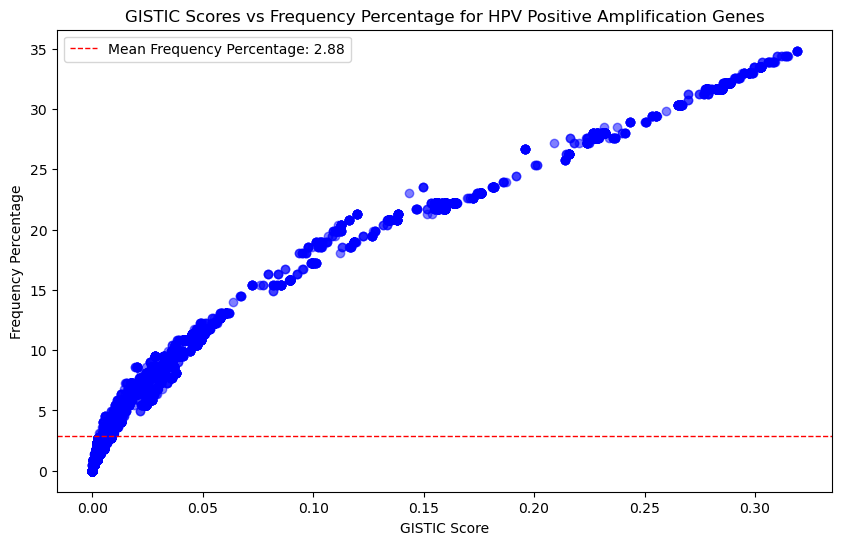

In [105]:
### plot distribution of gistic scores vs frequency percatage
plt.figure(figsize=(10, 6))
plt.scatter(hpv_positive_amplification_gene_df['gistic_score'], hpv_positive_amplification_gene_df['frequency_percentage'], alpha=0.5, color='blue')
plt.title('GISTIC Scores vs Frequency Percentage for HPV Positive Amplification Genes')
plt.xlabel('GISTIC Score')
plt.ylabel('Frequency Percentage')
plt.axhline(y=hpv_positive_amplification_gene_df['frequency_percentage'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean Frequency Percentage: {hpv_positive_amplification_gene_df["frequency_percentage"].mean():.2f}')
plt.legend()
plt.show()

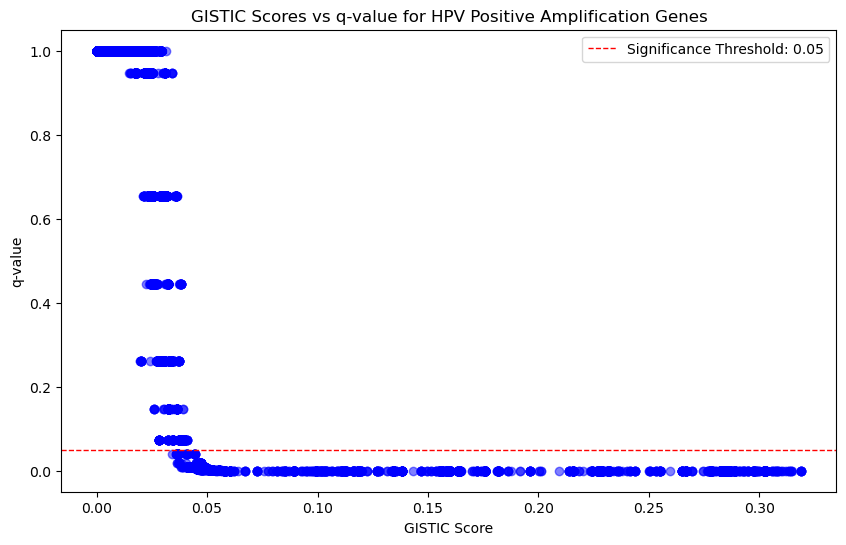

In [106]:
## plot gistic score vs q value
plt.figure(figsize=(10, 6))
plt.scatter(hpv_positive_amplification_gene_df['gistic_score'], hpv_positive_amplification_gene_df['q_value'], alpha=0.5, color='blue')
plt.title('GISTIC Scores vs q-value for HPV Positive Amplification Genes')
plt.xlabel('GISTIC Score')
plt.ylabel('q-value')
plt.axhline(y=0.05, color='red', linestyle='dashed', linewidth=1, label='Significance Threshold: 0.05')
plt.legend()
plt.show()

In [107]:
hpv_positive_amplification_gene_df

gene   gene_name  Sample_size  amplification_count  \
0      ENSG00000242512.9   LINC01206          221                   77   
1      ENSG00000252257.1   RN7SKP265          221                   77   
2      ENSG00000266317.2   RN7SL703P          221                   77   
3      ENSG00000213155.4  AC007547.1          221                   77   
4      ENSG00000239805.1  AC007547.2          221                   77   
...                  ...         ...          ...                  ...   
60618  ENSG00000255350.1    MTCO1P15          221                    0   
60619  ENSG00000227120.1  AC009238.1          221                    0   
60620  ENSG00000226540.2    GAPDHP73          221                    0   
60621  ENSG00000053328.8     METTL24          221                    0   
60622  ENSG00000217878.2  AL136100.1          221                    0   

       Amplification_sum (i.e. total log2(amplification CNV) across samples)  \
0                                             202.286944                       
1                                             202.286944                       
2                                             202.286944                       
3                                             202.286944                       
4                                             202.286944                       
...                                                  ...                       
60618                                           9.339850                       
60619                                          35.849625                       
60620                                          36.264663                       
60621                                          35.924813                       
60622                                          36.434588                       

       Amplification_sum_prevalence  frequency_percentage  gistic_score  \
0                          0.915326             34.841629      0.318914   
1                          0.915326             34.841629      0.318914   
2                          0.915326             34.841629      0.318914   
3                          0.915326             34.841629      0.318914   
4                          0.915326             34.841629      0.318914   
...                             ...                   ...           ...   
60618                      0.042262              0.000000      0.000000   
60619                      0.162215              0.000000      0.000000   
60620                      0.164093              0.000000      0.000000   
60621                      0.162556              0.000000      0.000000   
60622                      0.164862              0.000000      0.000000   

            p_value       q_value  significant  empirical_p_value  \
0      2.844552e-43  2.463504e-39         True           0.000999   
1      2.844552e-43  2.463504e-39         True           0.000999   
2      2.844552e-43  2.463504e-39         True           0.000999   
3      2.844552e-43  2.463504e-39         True           0.000999   
4      2.844552e-43  2.463504e-39         True           0.000999   
...             ...           ...          ...                ...   
60618  1.000000e+00  1.000000e+00        False           1.000000   
60619  1.000000e+00  1.000000e+00        False           1.000000   
60620  1.000000e+00  1.000000e+00        False           1.000000   
60621  1.000000e+00  1.000000e+00        False           1.000000   
60622  1.000000e+00  1.000000e+00        False           1.000000   

       empirical_q_value  empirical_significant chromosome      start  \
0               0.011719                   True       chr3  181952343   
1               0.011719                   True       chr3  181968459   
2               0.011719                   True       chr3  181813401   
3               0.011719                   True       chr3  181866351   
4               0.011719                   True       chr3  181847526   
..

In [108]:
## using plotly plot the distribution of gistic SCORES by gene name
def plot_gistic_distribution(df, title):
    ### plotly will add dots for significant incr
    import plotly.express as px
    fig = px.box(df, x='gene_name', y='gistic_score', title=title)
    ### add horizontal line cut off at .01
    fig.add_hline(y=0.29, line_dash="dash", line_color="red", annotation_text="Cutoff: 0.01", annotation_position="top left")
    fig.show()

In [109]:
plot_gistic_distribution(hpv_positive_amplification_gene_df, "HPV Positive Amplification Genes GISTIC2.0 Score Distribution")

In [110]:
### plot Amplification_sum (i.e. total log2(amplification CNV) across samples) of hpv_positive_amplification_gene_df
def plot_amplification_sum(df, title):
    """
    Function to plot the amplification sum of a DataFrame.
    The amplification sum is the total log2(amplification CNV) across samples.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(df['gene_name'], df['Amplification_sum (i.e. total log2(amplification CNV) across samples)'], color='blue', edgecolor='black')
    plt.axhline(y=0.01, color='red', linestyle='dashed', linewidth=1, label='Cutoff: 0.01')
    plt.title(title)
    plt.xlabel('Gene Name')
    plt.ylabel('Amplification Sum')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/1781921066.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



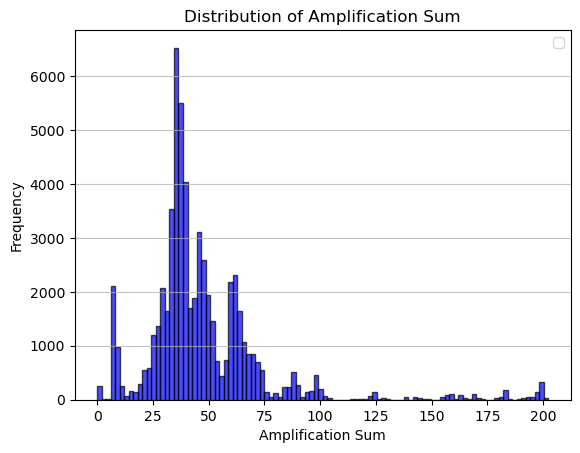

In [111]:
### plot histogram of Amplification_sum (i.e. total log2(amplification CNV) across samples) in hpv_positive_amplification_gene_df
plt.Figure(figsize=(10, 6))
plt.hist(hpv_positive_amplification_gene_df['Amplification_sum (i.e. total log2(amplification CNV) across samples)'], bins=100, alpha=0.7, color='blue', edgecolor='black')
#plt.axvline(0.01, color='red', linestyle='dashed', linewidth=1, label='Cutoff: 0.01')
plt.title('Distribution of Amplification Sum')
plt.xlabel('Amplification Sum')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

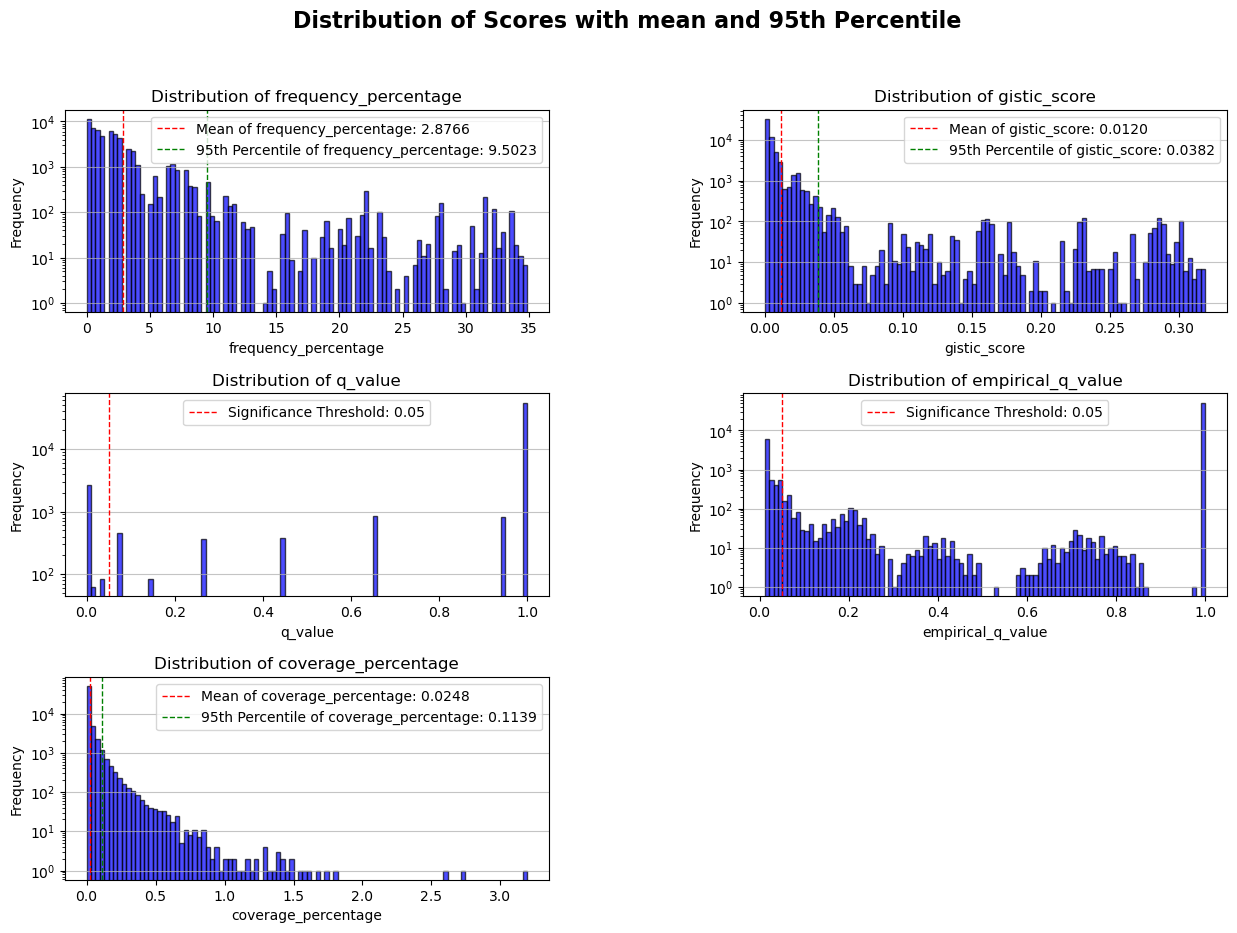

In [112]:
plot_score_distribution(hpv_positive_amplification_gene_df)

In [113]:
### decided cut offs
cutoffs = {
    'frequency_percentage': 30,
    'gistic_score': 0.296,
    'empirical_q_value': 0.05,
    'q_value': .05
}


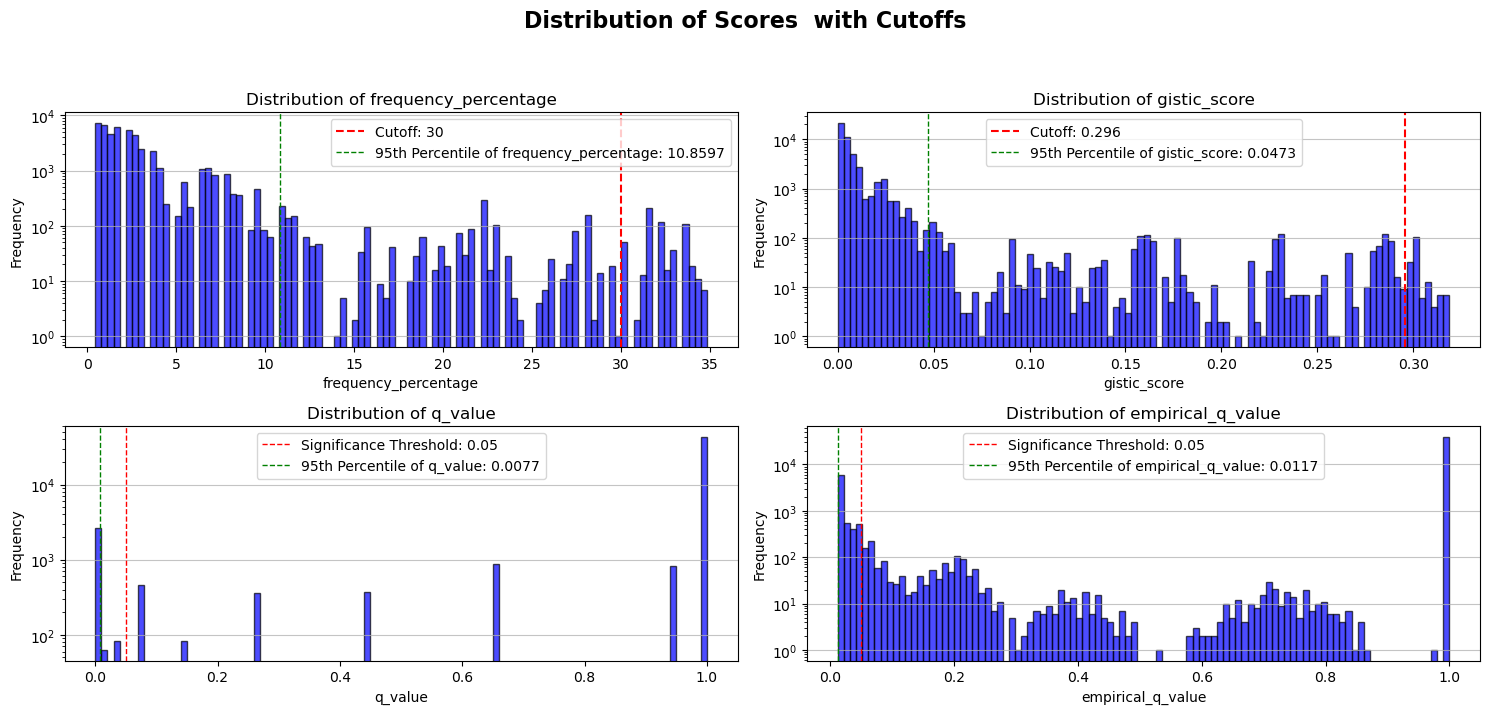

In [114]:
plot_score_distribution_with_cutoff(hpv_positive_amplification_gene_df, cutoffs)

In [115]:
hpv_positive_amplification_top_gene_df = hpv_positive_amplification_gene_df[hpv_positive_amplification_gene_df['frequency_percentage'] >= cutoffs['frequency_percentage']][hpv_positive_amplification_gene_df['gistic_score'] >= cutoffs['gistic_score']][hpv_positive_amplification_gene_df['q_value'] <= cutoffs['q_value']][hpv_positive_amplification_gene_df['empirical_q_value'] <= cutoffs['empirical_q_value']].copy()

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/1322974830.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/1322974830.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/1322974830.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [116]:
hpv_positive_amplification_top_gene_df

gene   gene_name  Sample_size  amplification_count  \
0     ENSG00000242512.9   LINC01206          221                   77   
1     ENSG00000252257.1   RN7SKP265          221                   77   
2     ENSG00000266317.2   RN7SL703P          221                   77   
3     ENSG00000213155.4  AC007547.1          221                   77   
4     ENSG00000239805.1  AC007547.2          221                   77   
..                  ...         ...          ...                  ...   
176   ENSG00000198398.2     TMEM207          221                   73   
177   ENSG00000236864.1  AC068295.1          221                   73   
178  ENSG00000114757.19       PEX5L          221                   73   
179   ENSG00000232610.1      CCT6P4          221                   73   
180   ENSG00000224187.1   LINC01991          221                   73   

     Amplification_sum (i.e. total log2(amplification CNV) across samples)  \
0                                           202.286944                       
1                                           202.286944                       
2                                           202.286944                       
3                                           202.286944                       
4                                           202.286944                       
..                                                 ...                       
176                                         199.033176                       
177                                         199.747422                       
178                                         198.794490                       
179                                         199.033176                       
180                                         199.747422                       

     Amplification_sum_prevalence  frequency_percentage  gistic_score  \
0                        0.915326             34.841629      0.318914   
1                        0.915326             34.841629      0.318914   
2                        0.915326             34.841629      0.318914   
3                        0.915326             34.841629      0.318914   
4                        0.915326             34.841629      0.318914   
..                            ...                   ...           ...   
176                      0.900603             33.031674      0.297484   
177                      0.903834             33.031674      0.298552   
178                      0.899523             33.031674      0.297127   
179                      0.900603             33.031674      0.297484   
180                      0.903834             33.031674      0.298552   

          p_value       q_value  significant  empirical_p_value  \
0    2.844552e-43  2.463504e-39         True           0.000999   
1    2.844552e-43  2.463504e-39         True           0.000999   
2    2.844552e-43  2.463504e-39         True           0.000999   
3    2.844552e-43  2.463504e-39         True           0.000999   
4    2.844552e-43  2.463504e-39         True           0.000999   
..            ...           ...          ...                ...   
176  2.637646e-39  8.834366e-37         True           0.000999   
177  2.637646e-39  8.834366e-37         True           0.000999   
178  2.637646e-39  8.834366e-37         True           0.000999   
179  2.637646e-39  8.834366e-37         True           0.000999   
180  2.637646e-39  8.834366e-37         True           0.000999   

     empirical_q_value  empirical_significant chromosome      start  \
0             0.011719                   True       chr3  181952343   
1             0.011719                   True       chr3  181968459   
2             0.011719                   True       chr3  181813401   
3             0.011719                   True       chr3  181866351   
4             0.011719                   True       chr3  181847526   
..                 ...                    ...        ...        ...   
176           0.011719    

In [117]:
### get unique genes in drugbank
drugbank_genes = list(set(Drug_bank['gene'].dropna().values))
### get unique genes in ppi
ppi_genes = list(set(protein_interaction['Translated_protein_1'].dropna().values) | set(protein_interaction['Translated_protein_2'].dropna().values))

In [118]:
# for gene in hpv_positive_amplification_top_gene_df[hpv_positive_amplification_gene_df['gene_name'].isin(drugbank_genes) |
#                                        hpv_positive_amplification_gene_df['gene_name'].isin(ppi_genes)]['gene_name']:
#     print(gene)

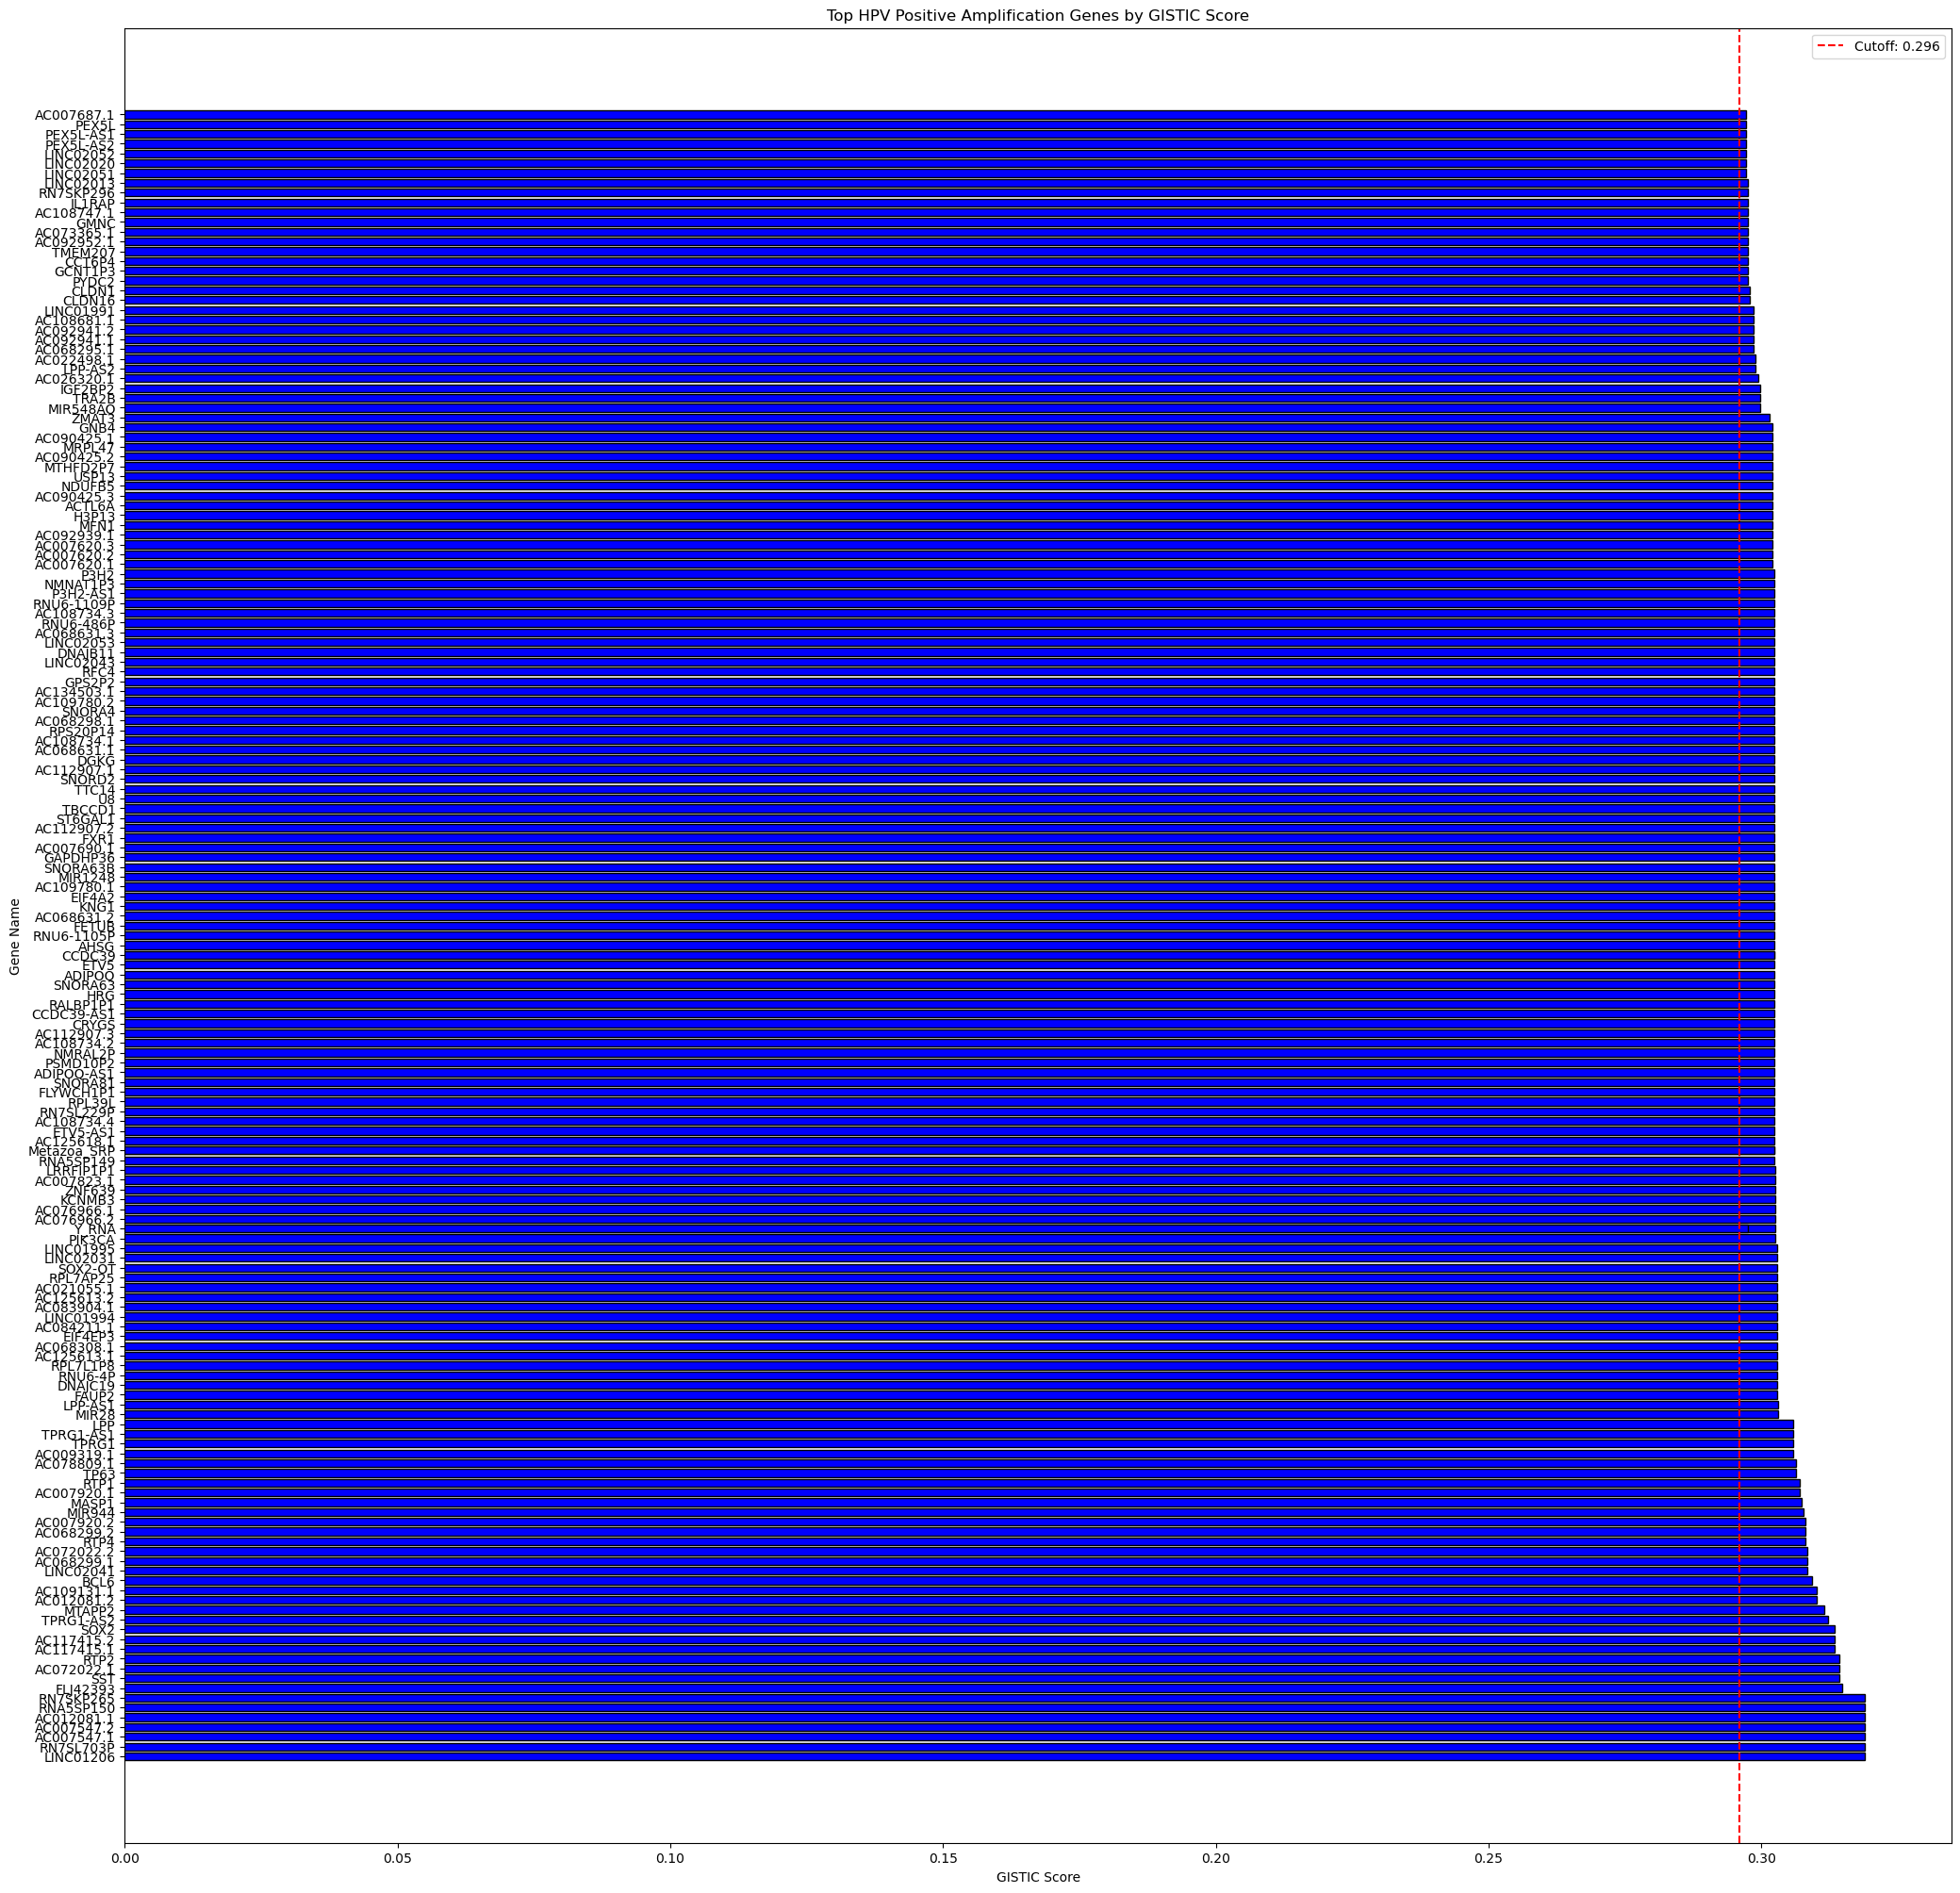

In [119]:
### plot gene vs gistic score
hpv_positive_amplification_top_gene_df.sort_values(by='gistic_score', ascending=False, inplace=True)
### make the plot larger to see all the genes
plt.figure(figsize=(25, 25))
plt.barh(hpv_positive_amplification_top_gene_df['gene_name'], hpv_positive_amplification_top_gene_df['gistic_score'], color='blue', edgecolor='black')
plt.axvline(x=cutoffs['gistic_score'], color='red', linestyle='--', label=f'Cutoff: {cutoffs["gistic_score"]}')
plt.title('Top HPV Positive Amplification Genes by GISTIC Score')
plt.xlabel('GISTIC Score')
plt.ylabel('Gene Name')
plt.legend()
plt.show()

In [120]:
### plot gene vs frequency percentage
hpv_positive_amplification_top_gene_df.sort_values(by='frequency_percentage', ascending=False, inplace=True)
### make the plot larger to see all the genes
plt.figure(figsize=(25, 25))
plt.barh(hpv_positive_amplification_top_gene_df['gene_name'], hpv_positive_amplification_top_gene_df['frequency_percentage'], color='blue', edgecolor='black')
plt.axvline(x=cutoffs['frequency_percentage'], color='red', linestyle='--', label=f'Cutoff: {cutoffs["frequency_percentage"]}')
plt.title('Top HPV Positive Amplification Genes by Frequency Percentage')
plt.xlabel('Frequency Percentage')
plt.ylabel('Gene Name')
plt.legend()
plt.show()

In [121]:
hpv_positive_amplification_top_gene_df.to_csv('Results/CNV results/HPV positive amplification top genes.csv', index=False)

#### Del

In [122]:
hpv_positive_deletion_gene_df

gene   gene_name  Sample_size  deletion_count  \
0      ENSG00000169239.13        CA5B          221              33   
1       ENSG00000279413.1  AC112497.2          221              33   
2       ENSG00000275800.1      EIF5P2          221              33   
3       ENSG00000200620.1  AC112497.1          221              33   
4      ENSG00000186312.10      CA5BP1          221              33   
...                   ...         ...          ...             ...   
60618   ENSG00000231880.2  KF459542.1          221               0   
60619   ENSG00000223727.6  AC034195.1          221               0   
60620   ENSG00000267233.1  HNRNPA3P16          221               0   
60621   ENSG00000286456.1  AC016769.5          221               0   
60622  ENSG00000156869.14       FRRS1          221               0   

       Deletion_sum (i.e. total deletion CNV count across samples)  \
0                                                   -140             
1                                                   -140             
2                                                   -140             
3                                                   -140             
4                                                   -140             
...                                                  ...             
60618                                                -15             
60619                                                -31             
60620                                                 -6             
60621                                                 -4             
60622                                                 -1             

       Deletion_sum_prevalence  frequency_percentage  gistic_score  \
0                     0.633484             14.932127      0.094593   
1                     0.633484             14.932127      0.094593   
2                     0.633484             14.932127      0.094593   
3                     0.633484             14.932127      0.094593   
4                     0.633484             14.932127      0.094593   
...                        ...                   ...           ...   
60618                 0.067873              0.000000      0.000000   
60619                 0.140271              0.000000      0.000000   
60620                 0.027149              0.000000      0.000000   
60621                 0.018100              0.000000      0.000000   
60622                 0.004525              0.000000      0.000000   

            p_value   q_value  significant  empirical_p_value  \
0      2.284493e-08  0.000016         True           0.000999   
1      2.284493e-08  0.000016         True           0.000999   
2      2.284493e-08  0.000016         True           0.000999   
3      2.284493e-08  0.000016         True           0.000999   
4      2.284493e-08  0.000016         True           0.000999   
...             ...       ...          ...                ...   
60618  1.000000e+00  1.000000        False           1.000000   
60619  1.000000e+00  1.000000        False           1.000000   
60620  1.000000e+00  1.000000        False           1.000000   
60621  1.000000e+00  1.000000        False           1.000000   
60622  1.000000e+00  1.000000        False           1.000000   

       empirical_q_value  empirical_significant chromosome     start  \
0               0.025404                   True       chrX  15688830   
1               0.025404                   True       chrX  15702602   
2               0.025404                   True       chrX  19496378   
3               0.025404                   True       chrX  15716208   
4               0.025404                   True       chrX  15674932   
...                  ...                    ...        ...       ...   
60618           1.000000                  False      chr11  47577725   
60619           1.000000                  False       chr3   3250687   
60620           1.000000                  False      chr18  50814392 

In [123]:
plot_score_distribution(hpv_positive_deletion_gene_df)

In [124]:
cutoffs = {
    'frequency_percentage': 12,
    'gistic_score': .091,
    'empirical_q_value': 0.05,
    'q_value': 0.05
}

In [125]:
# hpv_positive_deletion_gene_df[hpv_positive_deletion_gene_df['q_value'] < .05]

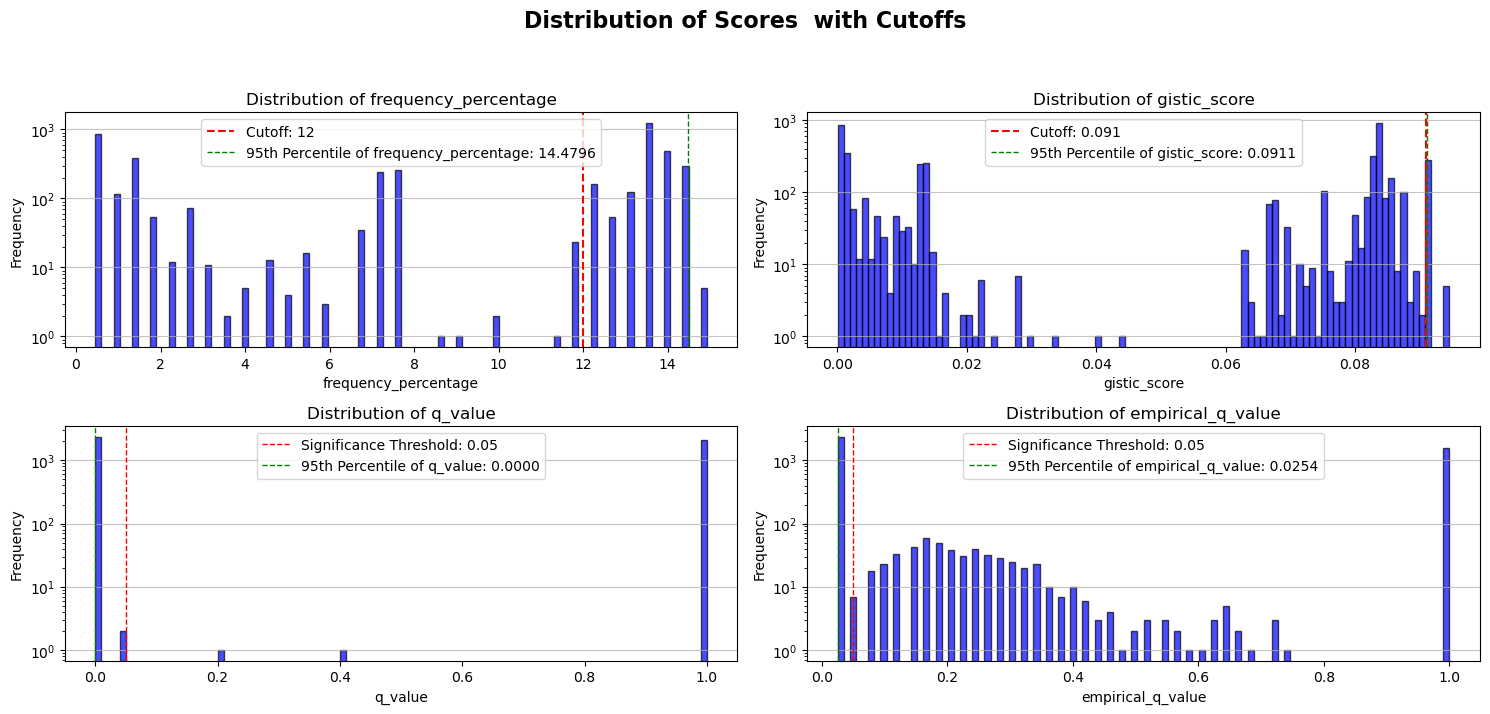

In [126]:
plot_score_distribution_with_cutoff(hpv_positive_deletion_gene_df, cutoffs)

In [127]:
### plot the gistic score distribution
plot_gistic_distribution(hpv_positive_deletion_gene_df, "GISTIC Score Distribution for HPV Positive Deletions")

In [128]:
hpv_positive_deletion_top_gene_df = hpv_positive_deletion_gene_df[hpv_positive_deletion_gene_df['frequency_percentage'] >= cutoffs['frequency_percentage']][hpv_positive_deletion_gene_df['gistic_score'] >= cutoffs['gistic_score']][hpv_positive_deletion_gene_df['empirical_q_value'] <= cutoffs['empirical_q_value']][hpv_positive_deletion_gene_df['q_value'] <= cutoffs['q_value']].copy()

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/3512978537.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/3512978537.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/3512978537.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



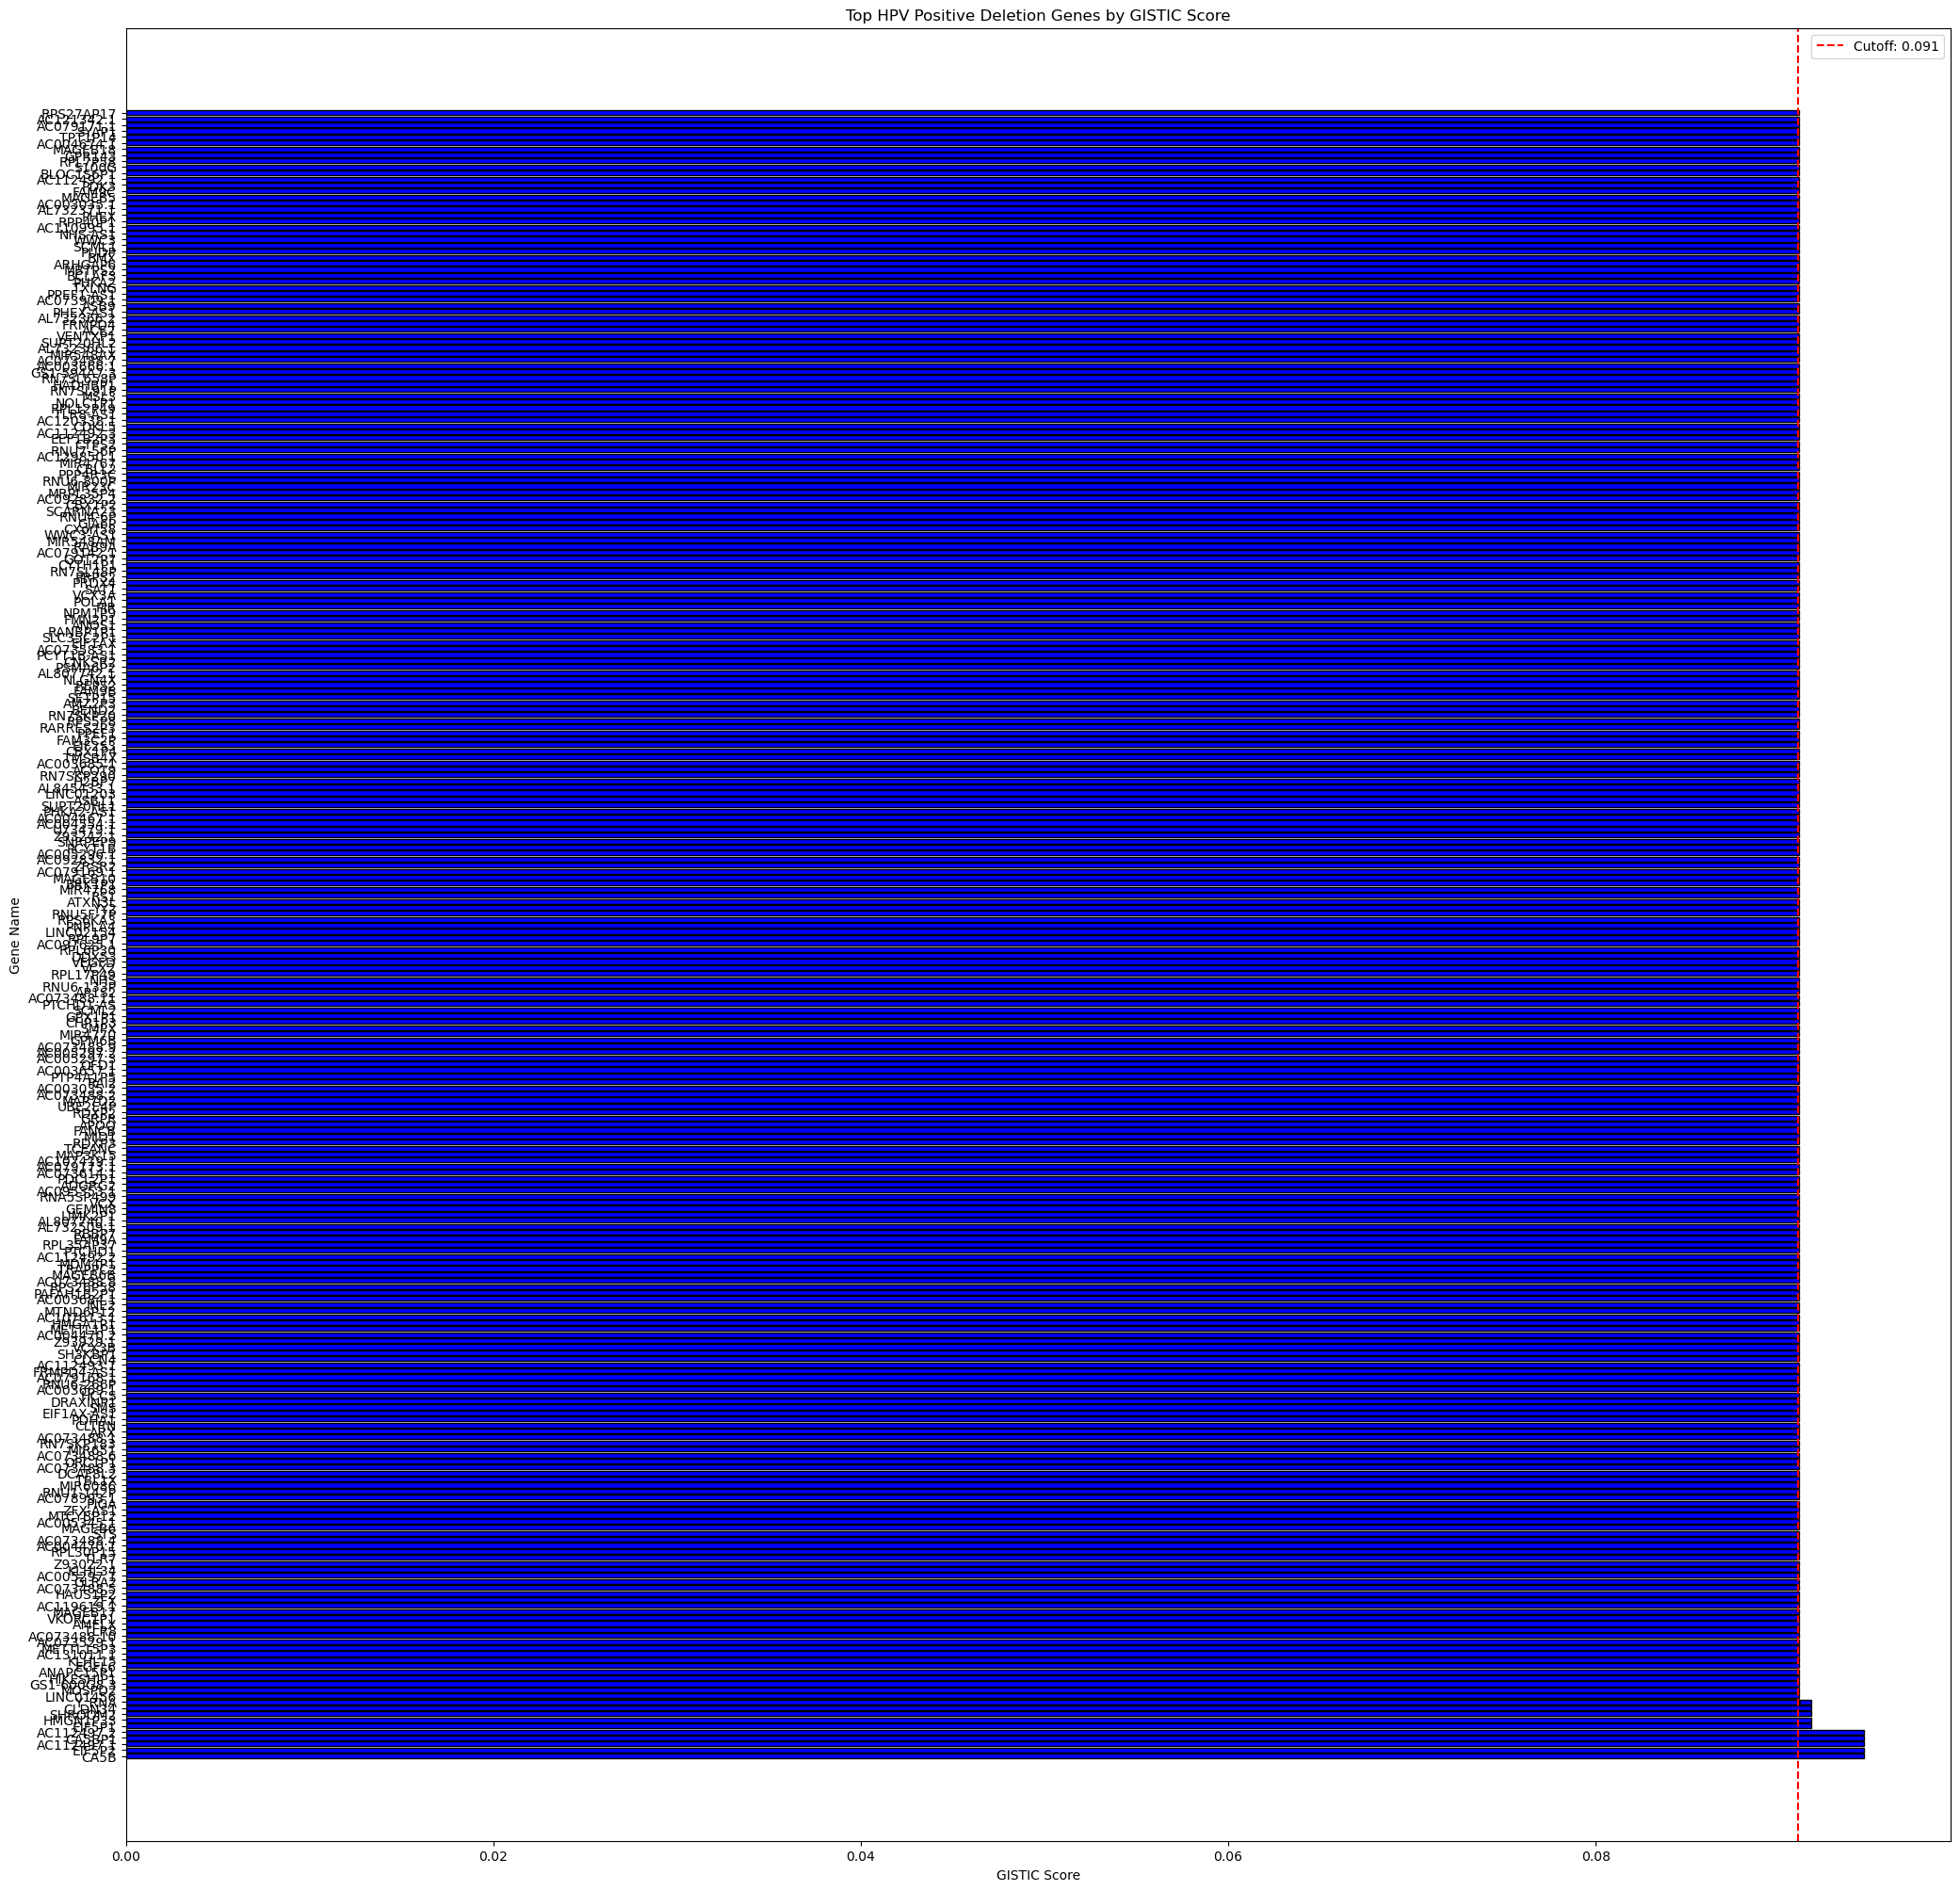

In [129]:
### plot gene vs gistic score
hpv_positive_deletion_top_gene_df.sort_values(by='gistic_score', ascending=False, inplace=True)
### make the plot larger to see all the genes
plt.figure(figsize=(25, 25))
plt.barh(hpv_positive_deletion_top_gene_df['gene_name'], hpv_positive_deletion_top_gene_df['gistic_score'], color='blue', edgecolor='black')
plt.axvline(x=cutoffs['gistic_score'], color='red', linestyle='--', label=f'Cutoff: {cutoffs["gistic_score"]}')
plt.title('Top HPV Positive Deletion Genes by GISTIC Score')
plt.xlabel('GISTIC Score')
plt.ylabel('Gene Name')
plt.legend()
plt.show()

In [130]:
hpv_positive_deletion_top_gene_df

gene   gene_name  Sample_size  deletion_count  \
0    ENSG00000169239.13        CA5B          221              33   
2     ENSG00000275800.1      EIF5P2          221              33   
3     ENSG00000200620.1  AC112497.1          221              33   
4    ENSG00000186312.10      CA5BP1          221              33   
1     ENSG00000279413.1  AC112497.2          221              33   
..                  ...         ...          ...             ...   
107   ENSG00000206792.1       Y_RNA          221              32   
108   ENSG00000261030.1  AC079171.1          221              32   
109   ENSG00000206639.1       Y_RNA          221              32   
110   ENSG00000233403.1  AC121342.1          221              32   
296   ENSG00000237490.3   RPS27AP17          221              32   

     Deletion_sum (i.e. total deletion CNV count across samples)  \
0                                                 -140             
2                                                 -140             
3                                                 -140             
4                                                 -140             
1                                                 -140             
..                                                 ...             
107                                               -139             
108                                               -139             
109                                               -139             
110                                               -139             
296                                               -139             

     Deletion_sum_prevalence  frequency_percentage  gistic_score  \
0                   0.633484             14.932127      0.094593   
2                   0.633484             14.932127      0.094593   
3                   0.633484             14.932127      0.094593   
4                   0.633484             14.932127      0.094593   
1                   0.633484             14.932127      0.094593   
..                       ...                   ...           ...   
107                 0.628959             14.479638      0.091071   
108                 0.628959             14.479638      0.091071   
109                 0.628959             14.479638      0.091071   
110                 0.628959             14.479638      0.091071   
296                 0.628959             14.479638      0.091071   

          p_value   q_value  significant  empirical_p_value  \
0    2.284493e-08  0.000016         True           0.000999   
2    2.284493e-08  0.000016         True           0.000999   
3    2.284493e-08  0.000016         True           0.000999   
4    2.284493e-08  0.000016         True           0.000999   
1    2.284493e-08  0.000016         True           0.000999   
..            ...       ...          ...                ...   
107  7.686503e-08  0.000016         True           0.000999   
108  7.686503e-08  0.000016         True           0.000999   
109  7.686503e-08  0.000016         True           0.000999   
110  7.686503e-08  0.000016         True           0.000999   
296  7.686503e-08  0.000016         True           0.000999   

     empirical_q_value  empirical_significant chromosome     start       end  \
0             0.025404                   True       chrX  15688830  15788411   
2             0.025404                   True       chrX  19496378  19497721   
3             0.025404                   True       chrX  15716208  15716346   
4             0.025404                   True       chrX  15674932  15703724   
1             0.025404                   True       chrX  15702602  15703243   
..                 ...                    ...        ...       ...       ...   
107           0.025404                   True       chrX  12054824  12054926   
108           0.025404                   True       chrX  13093660  13094573   
109           0.025404                   True       chrX  21872707  21872808   
110        

In [131]:
len(set(hpv_positive_deletion_top_gene_df['gene_name']))

274

In [132]:
hpv_positive_deletion_top_gene_df.to_csv('Results/CNV results/HPV positive deletion top genes.csv', index=False)

### HPV-

#### Amp

In [133]:
hpv_negative_amplification_gene_df

gene   gene_name  Sample_size  amplification_count  \
0             ENSG00000216058.1      MIR944         2218                  842   
1             ENSG00000230115.1   TPRG1-AS2         2218                  838   
2            ENSG00000073282.14        TP63         2218                  830   
3             ENSG00000230077.1      MTAPP2         2218                  830   
4             ENSG00000238026.1  AC117434.1         2218                  827   
...                         ...         ...          ...                  ...   
60618  ENSG00000182484.15_PAR_Y      WASH6P         2218                    0   
60619         ENSG00000230724.9   LINC01001         2218                    0   
60620         ENSG00000283274.1   5_8S_rRNA         2218                    0   
60621   ENSG00000277120.5_PAR_Y     MIR6089         2218                    0   
60622         ENSG00000223256.1   RNU6-785P         2218                    0   

       Amplification_sum (i.e. total log2(amplification CNV) across samples)  \
0                                            2037.446037                       
1                                            2034.022886                       
2                                            2018.173416                       
3                                            2031.770475                       
4                                            2003.074297                       
...                                                  ...                       
60618                                           0.000000                       
60619                                          15.849625                       
60620                                           0.000000                       
60621                                           0.000000                       
60622                                           0.000000                       

       Amplification_sum_prevalence  frequency_percentage  gistic_score  \
0                          0.918596             37.962128      0.348719   
1                          0.917053             37.781785      0.346479   
2                          0.909907             37.421100      0.340497   
3                          0.916037             37.421100      0.342791   
4                          0.903099             37.285843      0.336728   
...                             ...                   ...           ...   
60618                      0.000000              0.000000      0.000000   
60619                      0.007146              0.000000      0.000000   
60620                      0.000000              0.000000      0.000000   
60621                      0.000000              0.000000      0.000000   
60622                      0.000000              0.000000      0.000000   

       p_value  q_value  significant  empirical_p_value  empirical_q_value  \
0          0.0      0.0         True           0.000999           0.003858   
1          0.0      0.0         True           0.000999           0.003858   
2          0.0      0.0         True           0.000999           0.003858   
3          0.0      0.0         True           0.000999           0.003858   
4          0.0      0.0         True           0.000999           0.003858   
...        ...      ...          ...                ...                ...   
60618      1.0      1.0        False           1.000000           1.000000   
60619      1.0      1.0        False           1.000000           1.000000   
60620      1.0      1.0        False           1.000000           1.000000   
60621      1.0      1.0        False           1.000000           1.000000   
60622      1.0      1.0        False           1.000000           1.000000   

       empirical_significant chromosome      start        end  length  \
0                       True       chr3  189829922  189830009      88   
1                       True       chr3  189238686  189240594    1909   
2                       True       c

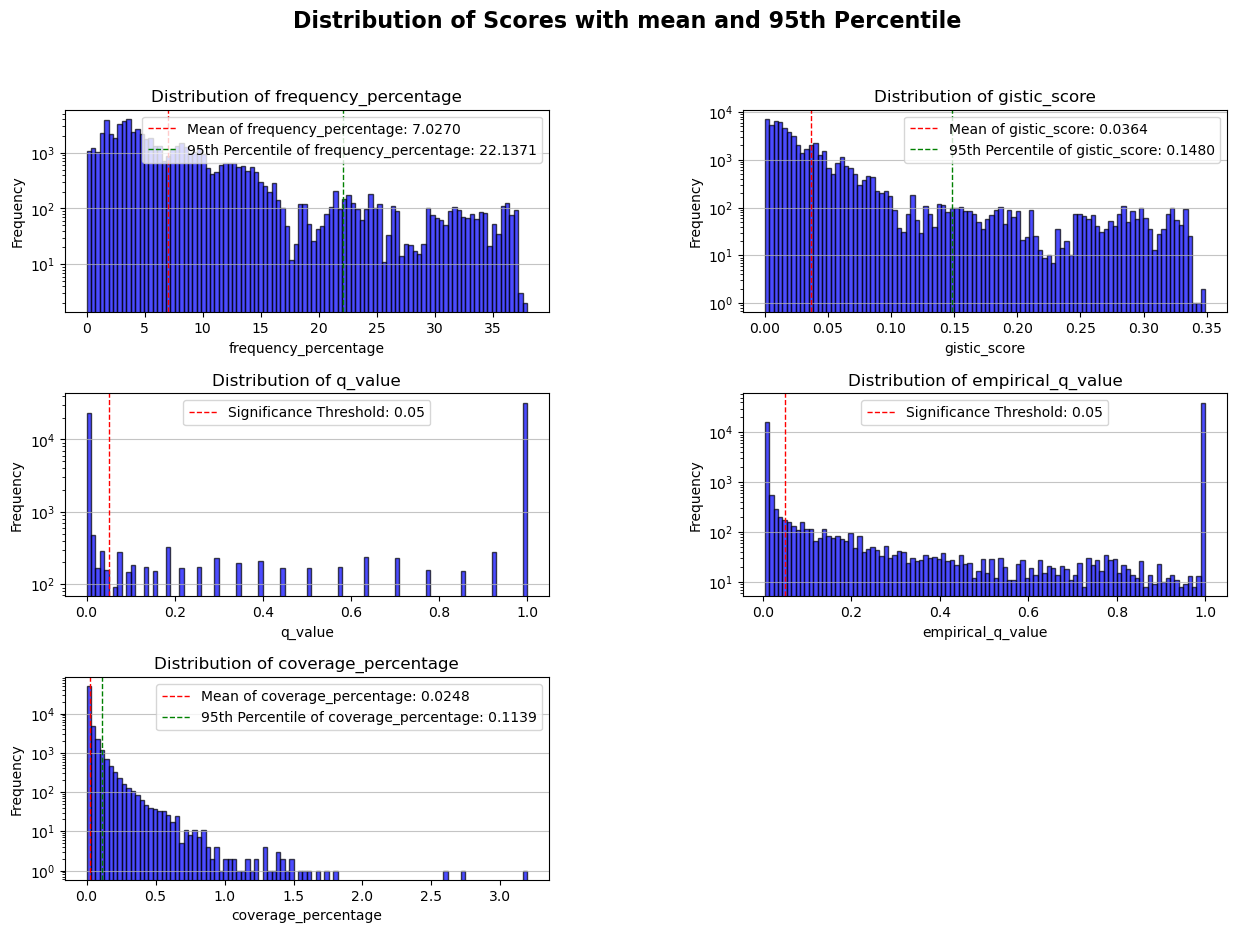

In [134]:
plot_score_distribution(hpv_negative_amplification_gene_df)

In [135]:
cutoffs = {
    'frequency_percentage': 35,
    'gistic_score': 0.31,
    'empirical_q_value': 0.05,
    'q_value': 0.05
}

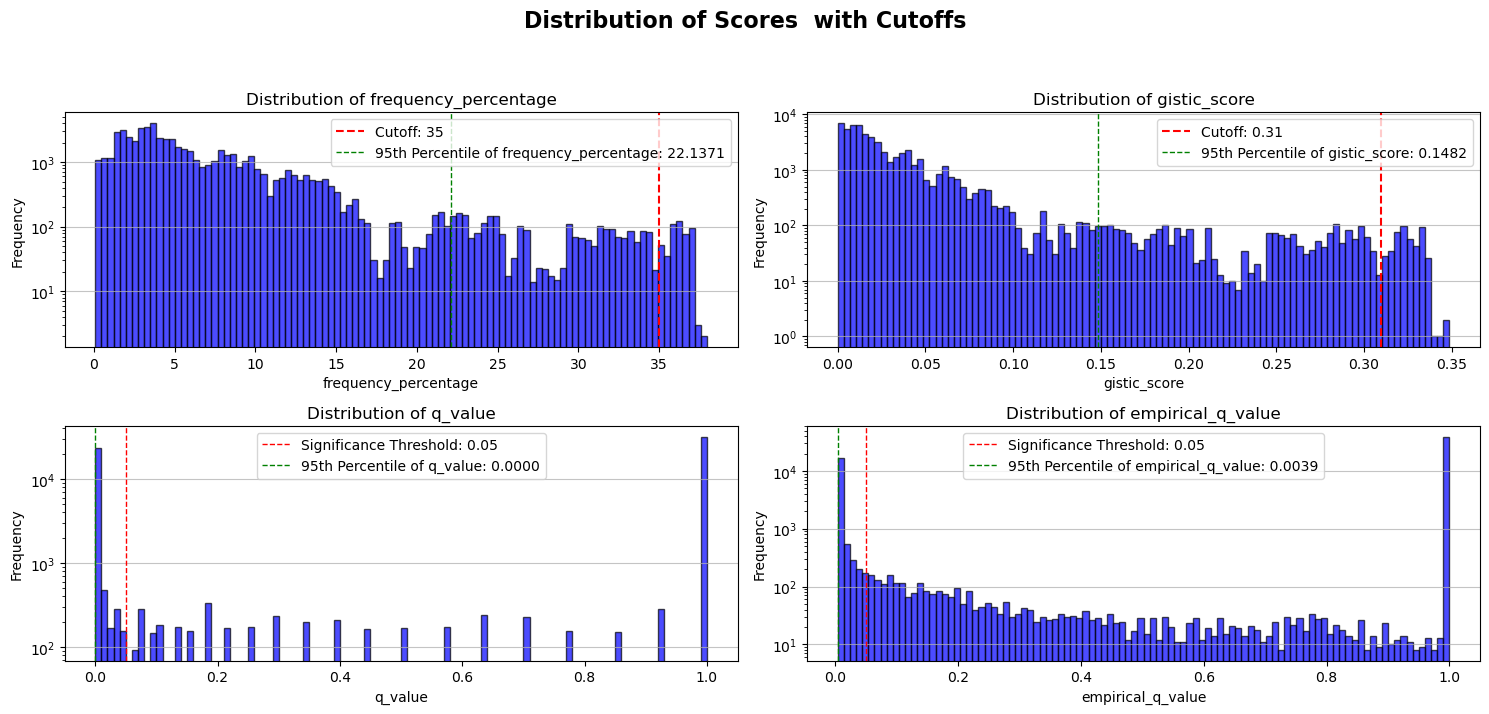

In [136]:
plot_score_distribution_with_cutoff(hpv_negative_amplification_gene_df, cutoffs)

In [137]:
hpv_negative_amplification_top_gene_df = hpv_negative_amplification_gene_df[hpv_negative_amplification_gene_df['frequency_percentage'] >= cutoffs['frequency_percentage']][hpv_negative_amplification_gene_df['gistic_score'] >= cutoffs['gistic_score']][hpv_negative_amplification_gene_df['empirical_q_value'] <= cutoffs['empirical_q_value']][hpv_negative_amplification_gene_df['q_value'] <= cutoffs['q_value']].copy()

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/2164227501.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/2164227501.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/2164227501.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [138]:
hpv_negative_amplification_top_gene_df

gene   gene_name  Sample_size  amplification_count  \
0     ENSG00000216058.1      MIR944         2218                  842   
1     ENSG00000230115.1   TPRG1-AS2         2218                  838   
2    ENSG00000073282.14        TP63         2218                  830   
3     ENSG00000230077.1      MTAPP2         2218                  830   
4     ENSG00000238026.1  AC117434.1         2218                  827   
..                  ...         ...          ...                  ...   
470   ENSG00000233308.2    OSTN-AS1         2218                  779   
471   ENSG00000201860.1       Y_RNA         2218                  779   
472   ENSG00000253548.1       PYDC2         2218                  779   
479   ENSG00000232353.5  AC026320.1         2218                  778   
483   ENSG00000237653.2  AC026320.2         2218                  778   

     Amplification_sum (i.e. total log2(amplification CNV) across samples)  \
0                                          2037.446037                       
1                                          2034.022886                       
2                                          2018.173416                       
3                                          2031.770475                       
4                                          2003.074297                       
..                                                 ...                       
470                                        1963.912339                       
471                                        1964.438408                       
472                                        1964.438408                       
479                                        1964.642549                       
483                                        1964.642549                       

     Amplification_sum_prevalence  frequency_percentage  gistic_score  \
0                        0.918596             37.962128      0.348719   
1                        0.917053             37.781785      0.346479   
2                        0.909907             37.421100      0.340497   
3                        0.916037             37.421100      0.342791   
4                        0.903099             37.285843      0.336728   
..                            ...                   ...           ...   
470                      0.885443             35.121731      0.310983   
471                      0.885680             35.121731      0.311066   
472                      0.885680             35.121731      0.311066   
479                      0.885772             35.076646      0.310699   
483                      0.885772             35.076646      0.310699   

     p_value  q_value  significant  empirical_p_value  empirical_q_value  \
0        0.0      0.0         True           0.000999           0.003858   
1        0.0      0.0         True           0.000999           0.003858   
2        0.0      0.0         True           0.000999           0.003858   
3        0.0      0.0         True           0.000999           0.003858   
4        0.0      0.0         True           0.000999           0.003858   
..       ...      ...          ...                ...                ...   
470      0.0      0.0         True           0.000999           0.003858   
471      0.0      0.0         True           0.000999           0.003858   
472      0.0      0.0         True           0.000999           0.003858   
479      0.0      0.0         True           0.000999           0.003858   
483      0.0      0.0         True           0.000999           0.003858   

     empirical_significant chromosome      start        end  length  \
0                     True       chr3  189829922  189830009      88   
1                     True       chr3  189238686  189240594    1909   
2                     True       chr3  189631389  189897276  265888   
3                     True       chr3  189969030  189969861     832   
4                     True       chr3  176113702  176114537 

In [139]:
hpv_negative_amplification_top_gene_df.to_csv('Results/CNV results/HPV negative amplification top genes.csv', index=False)

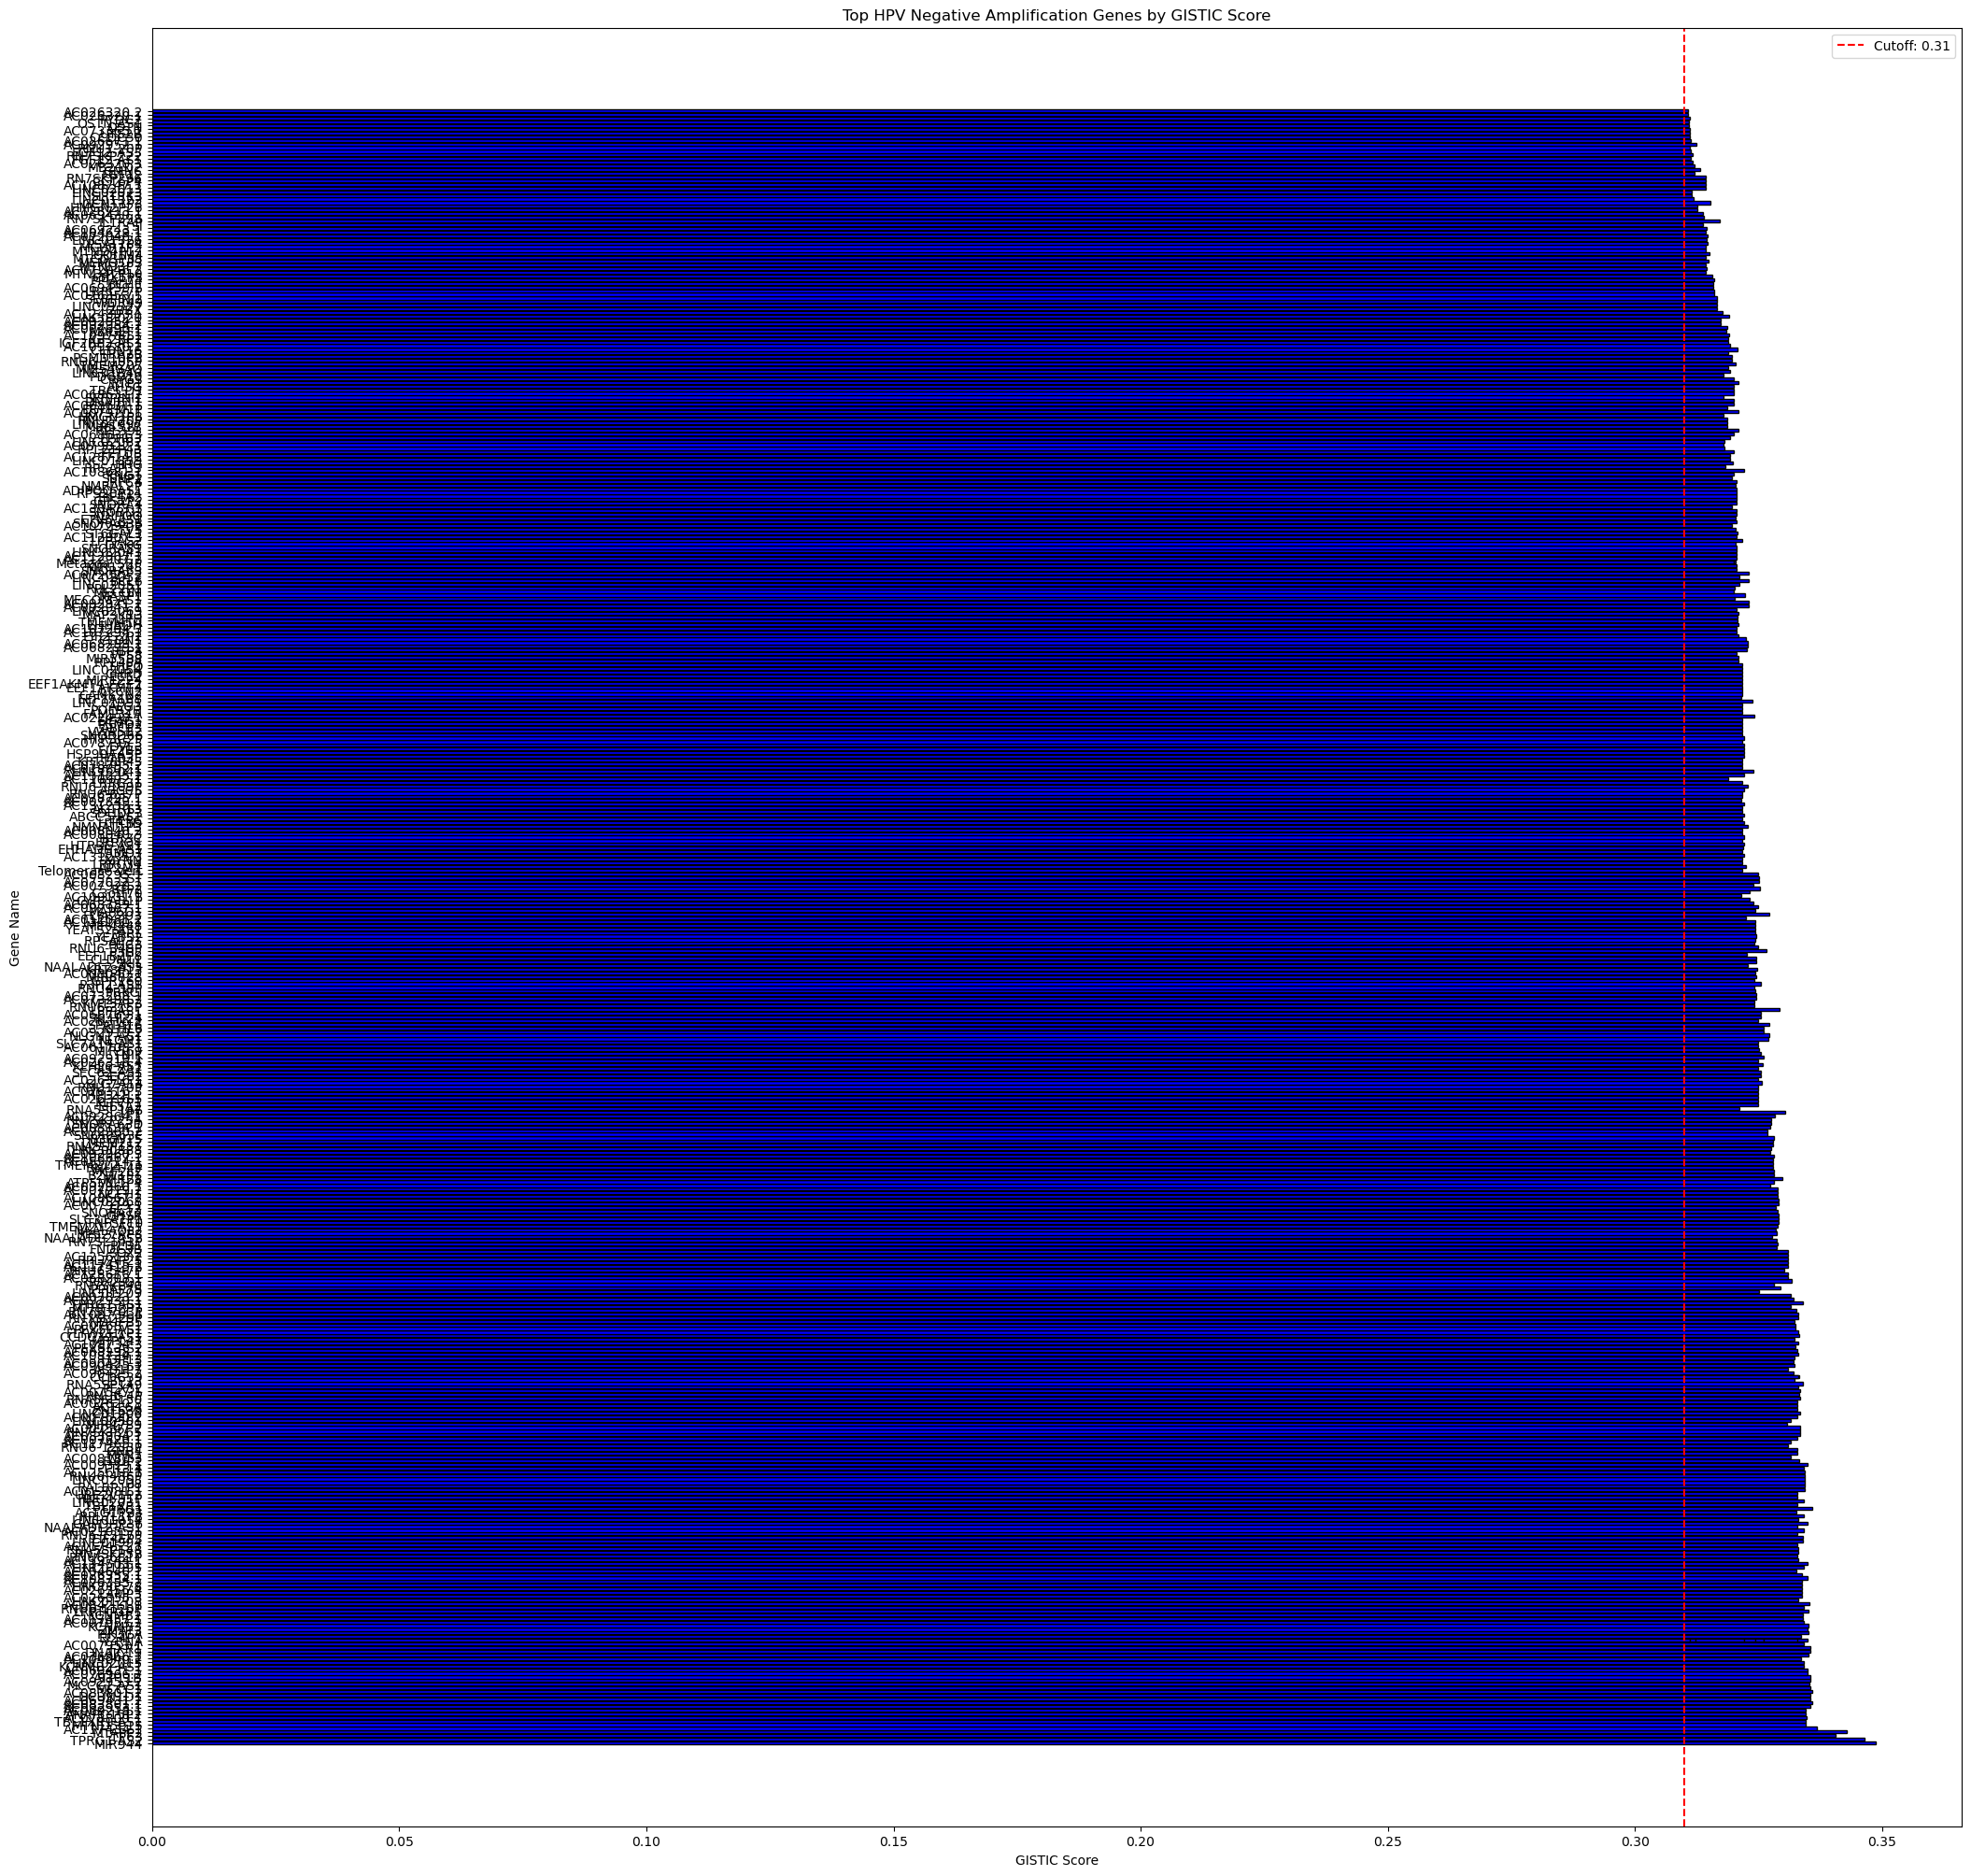

In [140]:
### plot gene vs gistic score
plt.figure(figsize=(25, 25))
plt.barh(hpv_negative_amplification_top_gene_df['gene_name'], hpv_negative_amplification_top_gene_df['gistic_score'], color='blue', edgecolor='black')
plt.axvline(x=cutoffs['gistic_score'], color='red', linestyle='--', label=f'Cutoff: {cutoffs["gistic_score"]}')
plt.title('Top HPV Negative Amplification Genes by GISTIC Score')
plt.xlabel('GISTIC Score')
plt.ylabel('Gene Name')
plt.legend()
plt.show()

#### Del

In [141]:
hpv_negative_deletion_gene_df

gene   gene_name  Sample_size  deletion_count  \
0       ENSG00000232634.1      NEFLP1         2218             538   
1       ENSG00000271123.1      ELOCP5         2218             538   
2       ENSG00000226042.1      CDY10P         2218             538   
3       ENSG00000230029.1      CDY11P         2218             538   
4       ENSG00000223637.7     RBMY2EP         2218             538   
...                   ...         ...          ...             ...   
60618   ENSG00000250326.2  AC104596.1         2218               0   
60619   ENSG00000260012.1  AC007494.1         2218               0   
60620  ENSG00000110851.12       PRDM4         2218               0   
60621   ENSG00000273367.1  AL355472.3         2218               0   
60622  ENSG00000156869.14       FRRS1         2218               0   

       Deletion_sum (i.e. total deletion CNV count across samples)  \
0                                                  -1172             
1                                                  -1170             
2                                                  -1170             
3                                                  -1170             
4                                                  -1172             
...                                                  ...             
60618                                               -182             
60619                                                -96             
60620                                                -48             
60621                                                -10             
60622                                               -166             

       Deletion_sum_prevalence  frequency_percentage  gistic_score  \
0                     0.528404             24.256087      0.128170   
1                     0.527502             24.256087      0.127951   
2                     0.527502             24.256087      0.127951   
3                     0.527502             24.256087      0.127951   
4                     0.528404             24.256087      0.128170   
...                        ...                   ...           ...   
60618                 0.082056              0.000000      0.000000   
60619                 0.043282              0.000000      0.000000   
60620                 0.021641              0.000000      0.000000   
60621                 0.004509              0.000000      0.000000   
60622                 0.074842              0.000000      0.000000   

             p_value        q_value  significant  empirical_p_value  \
0      4.542668e-206  1.376951e-202         True           0.000999   
1      4.542668e-206  1.376951e-202         True           0.000999   
2      4.542668e-206  1.376951e-202         True           0.000999   
3      4.542668e-206  1.376951e-202         True           0.000999   
4      4.542668e-206  1.376951e-202         True           0.000999   
...              ...            ...          ...                ...   
60618   1.000000e+00   1.000000e+00        False           1.000000   
60619   1.000000e+00   1.000000e+00        False           1.000000   
60620   1.000000e+00   1.000000e+00        False           1.000000   
60621   1.000000e+00   1.000000e+00        False           1.000000   
60622   1.000000e+00   1.000000e+00        False           1.000000   

       empirical_q_value  empirical_significant chromosome      start  \
0               0.020412                   True       chrY   21221106   
1               0.020412                   True       chrY   21631683   
2               0.020412                   True       chrY   21637475   
3               0.020412                   True       chrY   21696570   
4               0.020412                   True       chrY   21394991   
...                  ...                    ...        ...        ...   
60618           1.000000                  False       chr4  142933195   
60619           1.000000                  False      chr16   

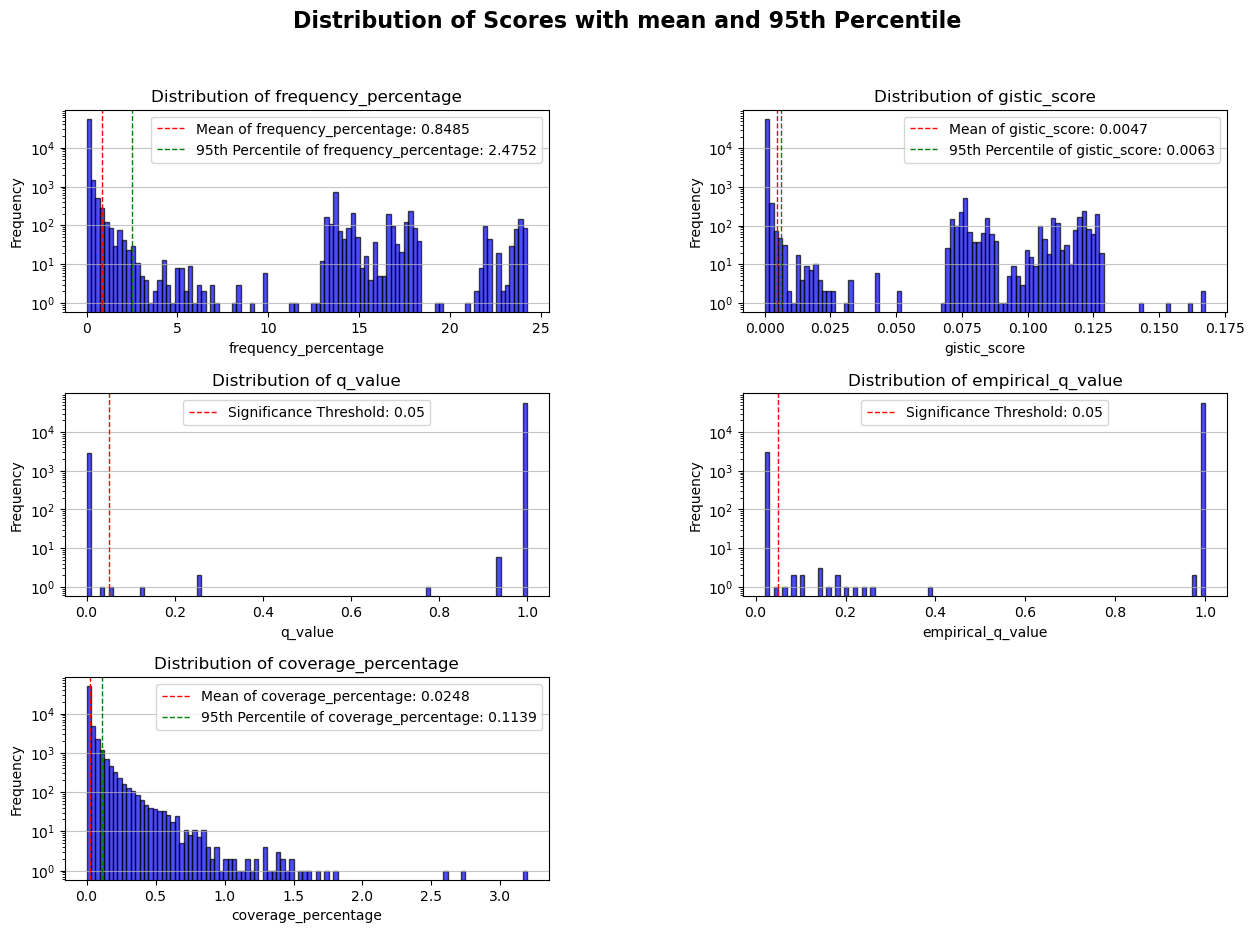

In [142]:
plot_score_distribution(hpv_negative_deletion_gene_df)

In [143]:
cutoffs = {
    'frequency_percentage': 22.5,
    'gistic_score': .12,
    'empirical_q_value': 0.05,
    'q_value': 0.05
}

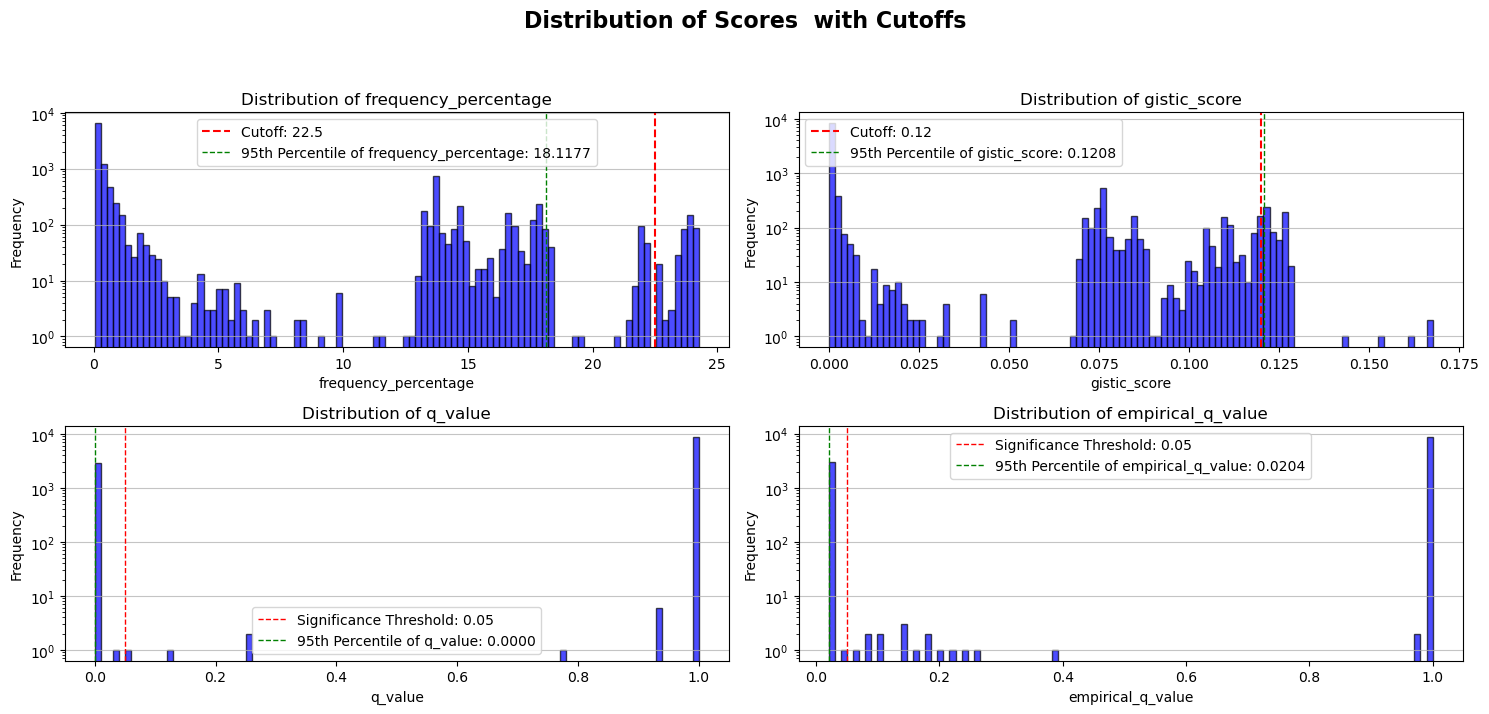

In [144]:
plot_score_distribution_with_cutoff(hpv_negative_deletion_gene_df, cutoffs)

In [145]:
hpv_negative_deletion_top_gene_df = hpv_negative_deletion_gene_df[hpv_negative_deletion_gene_df['frequency_percentage'] >= cutoffs['frequency_percentage']][hpv_negative_deletion_gene_df['gistic_score'] >= cutoffs['gistic_score']][hpv_negative_deletion_gene_df['empirical_q_value'] <= cutoffs['empirical_q_value']][hpv_negative_deletion_gene_df['q_value'] <= cutoffs['q_value']].copy()

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/3354478088.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/3354478088.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_56425/3354478088.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [146]:
hpv_negative_deletion_top_gene_df

gene gene_name  Sample_size  deletion_count  \
0    ENSG00000232634.1    NEFLP1         2218             538   
1    ENSG00000271123.1    ELOCP5         2218             538   
2    ENSG00000226042.1    CDY10P         2218             538   
3    ENSG00000230029.1    CDY11P         2218             538   
4    ENSG00000223637.7   RBMY2EP         2218             538   
..                 ...       ...          ...             ...   
314  ENSG00000226362.2  FAM41AY2         2218             524   
315  ENSG00000250951.1   USP9YP1         2218             524   
316  ENSG00000230663.1   FAM224B         2218             524   
317  ENSG00000226449.1     CDY5P         2218             524   
352  ENSG00000215221.2   UBA52P6         2218             510   

     Deletion_sum (i.e. total deletion CNV count across samples)  \
0                                                -1172             
1                                                -1170             
2                                                -1170             
3                                                -1170             
4                                                -1172             
..                                                 ...             
314                                              -1142             
315                                              -1142             
316                                              -1142             
317                                              -1142             
352                                              -1484             

     Deletion_sum_prevalence  frequency_percentage  gistic_score  \
0                   0.528404             24.256087      0.128170   
1                   0.527502             24.256087      0.127951   
2                   0.527502             24.256087      0.127951   
3                   0.527502             24.256087      0.127951   
4                   0.528404             24.256087      0.128170   
..                       ...                   ...           ...   
314                 0.514878             23.624887      0.121639   
315                 0.514878             23.624887      0.121639   
316                 0.514878             23.624887      0.121639   
317                 0.514878             23.624887      0.121639   
352                 0.669071             22.993688      0.153844   

           p_value        q_value  significant  empirical_p_value  \
0    4.542668e-206  1.376951e-202         True           0.000999   
1    4.542668e-206  1.376951e-202         True           0.000999   
2    4.542668e-206  1.376951e-202         True           0.000999   
3    4.542668e-206  1.376951e-202         True           0.000999   
4    4.542668e-206  1.376951e-202         True           0.000999   
..             ...            ...          ...                ...   
314  3.454177e-195  6.584986e-193         True           0.000999   
315  3.454177e-195  6.584986e-193         True           0.000999   
316  3.454177e-195  6.584986e-193         True           0.000999   
317  3.454177e-195  6.584986e-193         True           0.000999   
352  1.610721e-184  2.766197e-182         True           0.000999   

     empirical_q_value  empirical_significant chromosome     start       end  \
0             0.020412                   True       chrY  21221106  21222089   
1             0.020412                   True       chrY  21631683  21632015   
2             0.020412                   True       chrY  21637475  21639041   
3             0.020412                   True       chrY  21696570  21698220   
4             0.020412                   True       chrY  21394991  21401585   
..                 ...                    ...        ...       ...       ...   
314           0.020412                   True       chrY  18390994  18405046   
315           0.020412                   True       chrY  18540980  18544128   
316           0.020412                   True       ch

In [147]:
### plot gene vs gistic scores
plt.figure(figsize=(25, 25))
plt.barh(hpv_negative_deletion_top_gene_df['gene_name'], hpv_negative_deletion_top_gene_df['gistic_score'], color='blue', edgecolor='black')
plt.axvline(x=cutoffs['gistic_score'], color='red', linestyle='--', label=f'Cutoff: {cutoffs["gistic_score"]}')
plt.title('Top HPV Negative Deletion Genes by GISTIC Score')
plt.xlabel('GISTIC Score')
plt.ylabel('Gene Name')
plt.legend()
plt.show()

In [148]:
hpv_negative_deletion_top_gene_df.to_csv('Results/CNV results/HPV negative deletion top genes.csv', index=False)

In [149]:
top_hpv_negative_deletion_genes = list(hpv_negative_deletion_top_gene_df['gene_name'].values)

In [150]:
# Drug_bank[Drug_bank['gene'].isin(top_hpv_negative_deletion_genes)]